# **<h3 align="center">Machine Learning - Project</h3>**
## **<h3 align="center">6. Level 2 Multi-Class Classification</h3>**
### **<h3 align="center">Group 30 - Project</h3>**


### Group Members
| Name              | Email                        | Student ID |
|-------------------|------------------------------|------------|
| Alexandra Pinto   | 20211599@novaims.unl.pt      | 20211599   |
| Gonçalo Peres     | 20211625@novaims.unl.pt      | 20211625   |
| Leonor Mira       | 20240658@novaims.unl.pt      | 20240658   |
| Miguel Natário    | 20240498@novaims.unl.pt      | 20240498   |
| Nuno Bernardino   | 20211546@novaims.unl.pt      | 20211546    |

---

### **6. Level 2 Multi-Class Classification Notebook**
**Description:**
This notebook handles the **Level 2 Multi-Class Classification model**, which processes cases classified as "Other" in Level 1 and assigns them to their specific class among the rarer categories.

Key steps include:
- Loading the subset of “**Other**” cases from Level 1 predictions.
- **Feature selection:** Focus on features relevant for differentiating between the rare classes.
- **Model training:** Train and evaluate a multi-class classification model to predict the specific class of these cases.
- **Evaluation:** Use multi-class metrics like accuracy, macro-averaged F1-score, and confusion matrices.
- **Output:** Save predictions for merging in the final pipeline.

This notebook specializes in handling the complexity of rare classes, ensuring that all cases are correctly classified.

---

## Table of Contents
* [1. Import the Libraries](#chapter1)
* [2. Load and Prepare Datasets](#chapter2)
* [3. Setting the Target](#chapter3)
* [4. Feature Selection](#chapter4)
    * [4.1. Preparing the Data](#section_4_1)  
        * [4.1.1. Scaling the Numerical Data](#section_4_1_1)
        * [4.1.2. Encoding the Categorical Data](#section_4_1_2)
    * [4.2. Numerical Features](#section_4_2) 
        * [4.2.1. Spearman Correlation Matrix](#section_4_2_1)
        * [4.2.2. LASSO Regression](#section_4_2_2)
        * [4.2.3. Recursive Feature Elimination - RFE](#section_4_2_3)
        * [4.2.4. Feature Importance - Decision Tree](#section_4_2_4)
        * [4.2.5. Feature Importance - Random Forest](#section_4_2_5)
    * [4.3. Categorical Features](#section_4_3)
        * [4.3.1. $\chi ^2$ Test for Independence](#section_4_3_1)
        * [4.3.2. Mutual Information Criterion (MIC)](#section_4_3_2)
    * [4.4. Final Features](#section_4_4)
* [5. Modelling](#chapter5)
  * [5.1. Simple Models](#section_5_1)
    * [5.1.1. Logistic Regression](#section_5_1_1)
    * [5.1.2. Decision Trees](#section_5_1_2)
    * [5.1.3. K-Nearest Neighbors (KNN)](#section_5_1_3)
  * [5.2. Deep Learning Models](#section_5_2)
    * [5.2.1. Feedforward Neural Networks (FNN)](#section_5_2_1)
    * [5.2.2. Convolutional Neural Networks (CNN)](#section_5_2_2)
  * [5.3. Ensemble Models](#section_5_3)
    * [5.3.1. Bagging (Random Forest)](#section_5_3_1)
    * [5.3.2. Boosting (XGBoost, CatBoost, LightGBM)](#section_5_3_2)
    * [5.3.3. Stacking](#section_5_3_3)
* [6. Loading the Results](#chapter6)

# 1. Import the Libraries 📚<a class="anchor" id="chapter1"></a>

In [78]:
# --- Standard Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import zipfile


# --- Scikit-Learn Modules for Data Partitioning and Preprocessing ---
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder


# --- Feature Selection Methods ---
# Filter Methods
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.feature_selection import mutual_info_classif, chi2, SelectKBest

# Wrapper Methods
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Embedded Methods
from sklearn.linear_model import LassoCV

# --- Evaluation Metrics ---
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

#from xgboost import XGBClassifier

# --- Warnings ---


import warnings
warnings.filterwarnings('ignore')


#selecionar apenas as função que vamos usar neste :)
from utils import plot_importance, cor_heatmap, find_optimal_features_with_rfe, compare_rf_feature_importances,compare_feature_importances, select_high_score_features_chi2_no_model,select_high_score_features_MIC, metrics

# 2. Load and Prepare Datasets 📁<a class="anchor" id="chapter2"></a>
In this topic we will load the X_train and X_val preprocessed from Notebook 1, and the df_test with the prediction from notebook 3.

In [79]:
#Import the datasets
X_train = pd.read_csv("../processed_datasets/X_train_model.csv", index_col="Claim Identifier")
X_val = pd.read_csv("../processed_datasets/X_val_model.csv", index_col="Claim Identifier")
df_test = pd.read_csv("../processed_datasets/df_test_model.csv", index_col="Claim Identifier")

ValueError: Index Claim Identifier invalid

In [ ]:
X_train.head(2)

,Age at Injury,Attorney/Representative,Average Weekly Wage,Birth Year,Carrier Name,Carrier Type,County of Injury,COVID-19 Indicator,District Name,Gender,...,promptness_C2_category,promptness_C3_category,Zip_Code_Simplified,Carrier Type Merged,Carrier_Name_Simplified,Body_Part_Category,Injury_Nature_Category,Injury_Cause_Category,Industry Risk,Salary_Per_Dependent
Claim Identifier,,,,,,,,,,,,,,,,,,,,,
5479022,24,0.0,816.297482,1996.0,STATE INSURANCE FUND,SIF,CAYUGA,0.0,SYRACUSE,M,...,Until 1 week,No form received,OTHER,SIF,STATE INSURANCE FUND,Lower Extremities,Specific Injury,Strain or Injury By,Unknown Risk,204.074371
6023025,36,1.0,1097.000000,1986.0,SIRIUSPOINT AMERICA INSURANCE,PRIVATE,QUEENS,0.0,NYC,M,...,1 to 3 months,1 to 3 months,11368,PRIVATE,OTHER,Multiple Body Parts,Specific Injury,"Fall, Slip, or Trip",Unknown Risk,365.666667


In [5]:
X_val.head(2)

,Age at Injury,Attorney/Representative,Average Weekly Wage,Birth Year,Carrier Name,Carrier Type,County of Injury,COVID-19 Indicator,District Name,Gender,...,promptness_C2_category,promptness_C3_category,Zip_Code_Simplified,Carrier Type Merged,Carrier_Name_Simplified,Body_Part_Category,Injury_Nature_Category,Injury_Cause_Category,Industry Risk,Salary_Per_Dependent
Claim Identifier,,,,,,,,,,,,,,,,,,,,,
5893917,43,1.0,1537.747746,1978.101209,ACE AMERICAN INSURANCE CO.,PRIVATE,BRONX,0.0,NYC,M,...,3 to 6 months,3 to 6 months,10467,PRIVATE,ACE AMERICAN INSURANCE CO.,NaN,Occupational Disease or Cumulative Injury,Strain or Injury By,Unknown Risk,512.582582
5978089,59,0.0,1696.250000,1963.000000,ZURICH AMERICAN INSURANCE CO,PRIVATE,NIAGARA,0.0,BUFFALO,M,...,Until 1 week,No form received,14094,PRIVATE,ZURICH AMERICAN INSURANCE CO,NaN,Specific Injury,Struck or Injured by,Unknown Risk,424.062500


We will also upload the y train and y_val.

In [7]:
# Load the arrays
y_train = np.load("../processed_datasets/y_train_preprocessed.npy", allow_pickle=True)
y_val =  np.load("../processed_datasets/y_train_preprocessed.npy", allow_pickle=True)

In [8]:
pd.set_option('display.max_columns', None) # show all the columns

In [9]:
y_train

array(['2. NON-COMP', '4. TEMPORARY', '4. TEMPORARY', ...,
       '5. PPD SCH LOSS', '2. NON-COMP', '2. NON-COMP'], dtype=object)

In [10]:
df_test['Pred_notebook_3'].value_counts()

4. TEMPORARY    212961
2. NON-COMP         44
Name: Pred_notebook_3, dtype: int64

In [11]:
df_test['Pred_notebook_3'].isna().sum() 

174970

In [12]:
#Let's remove the column predictions from the df_test saving in a variable y_test
y_test = df_test['Pred_notebook_3']
df_test.drop('Pred_notebook_3', axis=1, inplace=True)

# 3. Setting the Target <a class="anchor" id="chapter3"></a>

In [13]:
y_test

Claim Identifier
6165911             NaN
6166141             NaN
6165907             NaN
6166047             NaN
6166102             NaN
               ...     
6553137    4. TEMPORARY
6553119    4. TEMPORARY
6553542    4. TEMPORARY
6553455    4. TEMPORARY
6553594             NaN
Name: Pred_notebook_3, Length: 387975, dtype: object

In [14]:
# Filtering out classes '2. NON-COMP' and '4. TEMPORARY'
X_train_min = X_train[~((y_train == '2. NON-COMP') | (y_train == '4. TEMPORARY'))]

y_train_min = y_train[~((y_train == '2. NON-COMP') | (y_train == '4. TEMPORARY'))]

# Print the shapes to confirm the filtering
print("Shape of X_train_min:", X_train_min.shape)
print("Shape of y_train_min:", y_train_min.shape)

Shape of X_train_min: (92619, 38)
Shape of y_train_min: (92619,)


In [15]:
# Filtering out classes '2. NON-COMP' and '4. TEMPORARY'
X_val_min = X_val[~((y_val == '2. NON-COMP') | (y_val == '4. TEMPORARY'))]

y_val_min = y_val[~((y_val == '2. NON-COMP') | (y_val == '4. TEMPORARY'))]

# Print the shapes to confirm the filtering
print("Shape of X_train_not_2_4:", X_val_min.shape)
print("Shape of y_train_not_2_4:", y_val_min.shape)

Shape of X_train_not_2_4: (40332, 38)
Shape of y_train_not_2_4: (40332,)


In [16]:
y_val_min

array(['3. MED ONLY', '5. PPD SCH LOSS', '6. PPD NSL', ...,
       '5. PPD SCH LOSS', '3. MED ONLY', '3. MED ONLY'], dtype=object)

#### __`Encoding the Target`__

In [17]:
# Create a LabelEncoder instance
encoder = LabelEncoder()

# Encode y_train_new and y_val_new
y_train_encoded = encoder.fit_transform(y_train_min)  # Fit and transform on y_train_mapped
y_val_encoded = encoder.transform(y_val_min)  # Only transform on y_train_mapped

In [18]:
# Verify that the target is encoded 
print(f'{y_train_encoded}')
y_val_encoded

[1 1 1 ... 1 2 2]


array([1, 2, 3, ..., 2, 1, 1])

# 4. Feature Selection <a class="anchor" id="chapter4"></a>

The feature selection process involves summarizing the essential features in the dataset to help the model focus on the most relevant information. Here, we assess the categorical and numerical variables in `X_train_processed` by examining unique values, descriptive statistics, and verifying the correctness of categorical bins and continuous feature distributions.

The `X_train_processed.describe(include='O').T` command provides an overview of the categorical features in the dataset, displaying the count, unique values, top (most frequent) category, and its frequency. This summary helps us understand the distribution and cardinality of each categorical feature, which is essential for feature selection and preprocessing.

#### Descriptive Statistics for Categorical Features

In [19]:
# Displaying descriptive statistics for categorical features in the training dataset
X_val_min.describe(include='O').T

,count,unique,top,freq
Carrier Name,40332,1274,STATE INSURANCE FUND,9063
Carrier Type,40332,8,PRIVATE,16763
County of Injury,40332,63,SUFFOLK,5058
District Name,40332,8,NYC,19136
Gender,40332,3,M,25513
Medical Fee Region,40332,5,IV,19776
Category Combination,40332,18,PRIVATE-M,10466
Carrier_District_Interaction,40332,48,PRIVATE_NYC,7308
Income_Category,40332,5,High Income,9667
Age Group,40332,4,Young Adult,20033


This table provides insight into the number of unique categories within each feature, assisting in identifying high-cardinality features that may need simplification or encoding before modeling.

In [20]:
X_train_min.columns

Index(['Age at Injury', 'Attorney/Representative', 'Average Weekly Wage',
       'Birth Year', 'Carrier Name', 'Carrier Type', 'County of Injury',
       'COVID-19 Indicator', 'District Name', 'Gender', 'IME-4 Count',
       'Industry Code', 'Medical Fee Region', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Zip Code',
       'Number of Dependents', 'Category Combination',
       'Carrier_District_Interaction', 'Income_Category',
       'Days_To_First_Hearing', 'Accident_Quarter', 'Accident_Year',
       'Accident Day', 'Accident on Weekend', 'Age Group',
       'promptness_category', 'promptness_C2_category',
       'promptness_C3_category', 'Zip_Code_Simplified', 'Carrier Type Merged',
       'Carrier_Name_Simplified', 'Body_Part_Category',
       'Injury_Nature_Category', 'Injury_Cause_Category', 'Industry Risk',
       'Salary_Per_Dependent'],
      dtype='object')

### Feature Categories
The features have been organized into three main categories: **Categorical Features**, **Binary Features**, and **Discrete Features**. Each category represents a different data type or structure, allowing for tailored preprocessing steps and analysis.

In [21]:
X_train_min.columns

Index(['Age at Injury', 'Attorney/Representative', 'Average Weekly Wage',
       'Birth Year', 'Carrier Name', 'Carrier Type', 'County of Injury',
       'COVID-19 Indicator', 'District Name', 'Gender', 'IME-4 Count',
       'Industry Code', 'Medical Fee Region', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Zip Code',
       'Number of Dependents', 'Category Combination',
       'Carrier_District_Interaction', 'Income_Category',
       'Days_To_First_Hearing', 'Accident_Quarter', 'Accident_Year',
       'Accident Day', 'Accident on Weekend', 'Age Group',
       'promptness_category', 'promptness_C2_category',
       'promptness_C3_category', 'Zip_Code_Simplified', 'Carrier Type Merged',
       'Carrier_Name_Simplified', 'Body_Part_Category',
       'Injury_Nature_Category', 'Injury_Cause_Category', 'Industry Risk',
       'Salary_Per_Dependent'],
      dtype='object')

In [22]:
# Updating the feature categories with the new columns created
categorical_columns = ['Carrier Name', 'Carrier Type', 'County of Injury',
       'District Name', 'Gender', 'IME-4 Count',
       'Industry Code', 'Medical Fee Region', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Zip Code',
    'Carrier_District_Interaction',
       'Income_Category', 'Age Group',
       'promptness_category', 'promptness_C2_category','promptness_C3_category', 'Zip_Code_Simplified',
       'Carrier Type Merged', 'Carrier_Name_Simplified', 'Body_Part_Category',
       'Injury_Nature_Category', 'Injury_Cause_Category', 'Industry Risk',
]

binary_columns = [
    'Attorney/Representative', 'COVID-19 Indicator',
     'Accident on Weekend'
]

discrete_columns = [ 'Number of Dependents', 'IME-4 Count',
    'Accident_Quarter', 'Accident_Year', 'Accident Day'
]

continuous_columns = ['Days_To_First_Hearing','Average Weekly Wage','Age at Injury',
                      'Salary_Per_Dependent'
                      ]

# Printing the feature categories
print("Categorical Features:", categorical_columns)
print("Binary Features:", binary_columns)
print("Discrete Features:", discrete_columns)
print("Continuous Features:", continuous_columns)

Categorical Features: ['Carrier Name', 'Carrier Type', 'County of Injury', 'District Name', 'Gender', 'IME-4 Count', 'Industry Code', 'Medical Fee Region', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Zip Code', 'Carrier_District_Interaction', 'Income_Category', 'Age Group', 'promptness_category', 'promptness_C2_category', 'promptness_C3_category', 'Zip_Code_Simplified', 'Carrier Type Merged', 'Carrier_Name_Simplified', 'Body_Part_Category', 'Injury_Nature_Category', 'Injury_Cause_Category', 'Industry Risk']
Binary Features: ['Attorney/Representative', 'COVID-19 Indicator', 'Accident on Weekend']
Discrete Features: ['Number of Dependents', 'IME-4 Count', 'Accident_Quarter', 'Accident_Year', 'Accident Day']
Continuous Features: ['Days_To_First_Hearing', 'Average Weekly Wage', 'Age at Injury', 'Salary_Per_Dependent']


## 4.1. Preparing Data</b> <a class="anchor" id="section_4_1"></a>
### 4.1.1. Scaling the Numerical Data  <a class="anchor" id="sub_section_4_1_1"></a>

**Converting Discrete Columns to Integer**

In this step, we ensure all discrete columns are converted to integer data types across the training, validation, and test datasets. This is crucial for consistent data handling and processing in subsequent steps.

In [ ]:
# Convert discrete columns to integer
for column in discrete_columns:
    X_train_min[column] = X_train[column].astype(int)
    X_val_min[column] = X_val[column].astype(int)
    df_test[column] = df_test[column].astype(int)

**Scaling Features**

We apply the RobustScaler to the discrete columns. RobustScaler is beneficial for data containing outliers, as it scales data based on the median and interquartile range. This helps normalize the distribution without being heavily affected by outliers. We also use the same scaler to transform validation and test data.

In [ ]:
X_train_min.shape

In [ ]:
#scaling features
from sklearn.preprocessing import MinMaxScaler
feat_scaler = MinMaxScaler()
X_train_min[discrete_columns + continuous_columns] = feat_scaler.fit_transform(X_train_min[discrete_columns + continuous_columns])

X_train_num_scaled = X_train_min[discrete_columns + continuous_columns]

#apply same transformation for val data
X_val_min[discrete_columns + continuous_columns] = feat_scaler.transform(X_val_min[discrete_columns + continuous_columns])

X_val_num_scaled = X_val_min[discrete_columns + continuous_columns]

#apply same transformation for test data
df_test_num_scaled = feat_scaler.transform(df_test[discrete_columns + continuous_columns])

#X_val, X_train
X_train_num_scaled.head(4)

**Variance Check After Scaling**

After scaling, we check the variance of each scaled feature to confirm that the features have been scaled properly. Lower variance after scaling indicates that data is normalized and less affected by magnitude differences.

In [ ]:
# Check variance of scaled data
X_train_num_scaled.var()

The output shows the variance of each discrete column in the scaled training set. These values help validate that the scaling process has achieved a consistent data distribution across features.

 ### 4.1.2. Encoding the Categorical Data <a class="anchor" id="sub_section_4_1_2"></a>

 We'll apply the Chi-squared test on categorical features to check for independence. This test is suitable for categorical data and helps identify features that have significant associations with the target variable.

In [ ]:
binary_columns

['Attorney/Representative', 'COVID-19 Indicator', 'Accident on Weekend']

In [ ]:
#To make sure that we keep the preprocessed dataset without the encoded columns
X_train_processed_copy = X_train_min.copy()
X_val_processed_copy = X_val_min.copy()
df_test_processed_copy = df_test.copy()

In [ ]:
X_train_processed_copy.shape

(306375, 38)

In [ ]:
X_val_processed_copy.shape

(131876, 38)

In [ ]:
X_val_processed_copy.columns

Index(['Age at Injury', 'Attorney/Representative', 'Average Weekly Wage',
       'Birth Year', 'Carrier Name', 'Carrier Type', 'County of Injury',
       'COVID-19 Indicator', 'District Name', 'Gender', 'IME-4 Count',
       'Industry Code', 'Medical Fee Region', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Zip Code',
       'Number of Dependents', 'Category Combination',
       'Carrier_District_Interaction', 'Income_Category',
       'Days_To_First_Hearing', 'Accident_Quarter', 'Accident_Year',
       'Accident Day', 'Accident on Weekend', 'Age Group',
       'promptness_category', 'promptness_C2_category',
       'promptness_C3_category', 'Zip_Code_Simplified', 'Carrier Type Merged',
       'Carrier_Name_Simplified', 'Body_Part_Category',
       'Injury_Nature_Category', 'Injury_Cause_Category', 'Industry Risk',
       'Salary_Per_Dependent'],
      dtype='object')

**Approach: Encoding Categorical Features with LabelEncoder, OneHotEncoder and Frequency encoder**

As our second approach we decided to perform different type of encoding according with each categorical variable. For ordinal features (those with an inherent order like age groups), Label Encoding is applied to assign each category a unique numerical value. For nominal features with low cardinality (few unique values), One-Hot Encoding is used to create binary columns representing each category. For high-cardinality features (many unique values like zip codes), Frequency Encoding is applied to convert categories to their frequency of occurrence, reducing dimensionality without introducing too many columns.

These encoding methods are used to properly represent categorical features in a numerical format while considering their characteristics (order or cardinality), which helps models interpret them effectively.

In [ ]:
X_train_processed_copy['District Name'].value_counts()

NYC           144490
ALBANY         46152
HAUPPAUGE      29996
BUFFALO        24808
SYRACUSE       24220
ROCHESTER      23052
BINGHAMTON     11707
STATEWIDE       1950
Name: District Name, dtype: int64

In [ ]:
# Example columns to encode
ordinal_features = ['promptness_category', 'promptness_C2_category','promptness_C3_category', 'Age Group', 'Income_Category', 'Industry Risk']
low_cardinality_cols = ['Gender', 'Medical Fee Region','Body_Part_Category',
       'Injury_Nature_Category', 'Injury_Cause_Category']
high_cardinality_cols = ['Carrier_Name_Simplified', 'Zip_Code_Simplified', 'Industry Code', 'County of Injury', 'Carrier Type Merged',
                         'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code','Carrier_District_Interaction', 'District Name']


# Check for NaN or nulls
print(X_val_processed_copy[ordinal_features + low_cardinality_cols + high_cardinality_cols].isnull().sum())

promptness_category               1291
promptness_C2_category             967
promptness_C3_category             554
Age Group                            0
Income_Category                      0
Industry Risk                        0
Gender                               0
Medical Fee Region                   0
Body_Part_Category              131876
Injury_Nature_Category            2511
Injury_Cause_Category             2510
Carrier_Name_Simplified              0
Zip_Code_Simplified                  0
Industry Code                        0
County of Injury                     0
Carrier Type Merged                  0
WCIO Cause of Injury Code            0
WCIO Nature of Injury Code           0
WCIO Part Of Body Code               0
Carrier_District_Interaction         0
District Name                        0
dtype: int64


###ISTO DEVERÁ DAR ZERO MISSING VALYES, SE DER ENTÃO APAGAR A CELULA DE BAIXO

In [ ]:
# #por agora antes de descobrir o erro

# # Substituir os valores NaN pela moda de cada coluna

# # Substituir NaNs por moda no conjunto de treino, validação e teste
# for col in ordinal_features + low_cardinality_cols + high_cardinality_cols:
#     # Calcular a moda da coluna no conjunto de treino
#     moda = X_train_processed_copy[col].mode()[0]
    
#     # Substituir NaNs nos três conjuntos de dados pela moda calculada
#     X_train_processed_copy[col] = X_train_processed_copy[col].fillna(moda)
#     X_val_processed_copy[col] = X_val_processed_copy[col].fillna(moda)
#     df_test_processed_copy[col] = df_test_processed_copy[col].fillna(moda)

# # Verificar se ainda existem valores ausentes
# print(X_train_processed_copy.isnull().sum())
# print(X_val_processed_copy.isnull().sum())
# print(df_test_processed_copy.isnull().sum())

Age at Injury                   0
Attorney/Representative         0
Average Weekly Wage             0
Birth Year                      0
Carrier Name                    0
Carrier Type                    0
County of Injury                0
COVID-19 Indicator              0
District Name                   0
Gender                          0
IME-4 Count                     0
Industry Code                   0
Medical Fee Region              0
WCIO Cause of Injury Code       0
WCIO Nature of Injury Code      0
WCIO Part Of Body Code          0
Zip Code                        0
Number of Dependents            0
Category Combination            0
Carrier_District_Interaction    0
Income_Category                 0
Days_To_First_Hearing           0
Accident_Quarter                0
Accident_Year                   0
Accident Day                    0
Accident on Weekend             0
Age Group                       0
promptness_category             0
promptness_C2_category          0
promptness_C3_

In [ ]:
df_test_processed_copy['Industry Risk'].value_counts()

Unknown Risk    293128
High Risk        85111
Medium Risk       9736
Name: Industry Risk, dtype: int64

In [ ]:
# Sum all the NaN values in the datasets
missing_values_total = (
    X_train_processed_copy.isnull().sum().sum() +
    X_val_processed_copy.isnull().sum().sum() +
    df_test_processed_copy.isnull().sum().sum()
)

print(f"Total NaN values in all  the datasets: {missing_values_total}")

Total NaN values in all  the datasets: 0


In [ ]:
#For now since the pre processing isnt finish lets replace nan by 0 the row tha has nan vlaues
X_train_processed_copy = X_train_processed_copy.fillna(0)

In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import pandas as pd

# Step 1: Label Encode ordinal features (features with intrinsic order)
label_encoder_1 = LabelEncoder()
for col in ordinal_features:
    # Ensure input is a column from the DataFrame
    print(f"Processing ordinal feature: {col}")
    X_train_processed_copy[col] = label_encoder_1.fit_transform(X_train_processed_copy[col])
    X_val_processed_copy[col] = label_encoder_1.transform(X_val_processed_copy[col])
    df_test_processed_copy[col] = label_encoder_1.transform(df_test_processed_copy[col])

# Step 2: One-Hot Encode low-cardinality nominal features
print("\nProcessing low-cardinality features for One-Hot Encoding...")
one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')  # Corrected argument

# Extract the subset of low-cardinality columns
low_cardinality_train = X_train_processed_copy[low_cardinality_cols]
low_cardinality_val = X_val_processed_copy[low_cardinality_cols]
low_cardinality_test = df_test_processed_copy[low_cardinality_cols]

# Apply One-Hot Encoding and convert sparse matrix to dense
one_hot_encoded_train = one_hot_encoder.fit_transform(low_cardinality_train).toarray()
one_hot_encoded_val = one_hot_encoder.transform(low_cardinality_val).toarray()
one_hot_encoded_test = one_hot_encoder.transform(low_cardinality_test).toarray()

# Get feature names for the encoded columns
feature_names = one_hot_encoder.get_feature_names_out(low_cardinality_cols)

# Convert One-Hot Encoded arrays to DataFrames with correct index and columns
one_hot_encoded_train_df = pd.DataFrame(one_hot_encoded_train, columns=feature_names, index=low_cardinality_train.index)
one_hot_encoded_val_df = pd.DataFrame(one_hot_encoded_val, columns=feature_names, index=low_cardinality_val.index)
one_hot_encoded_test_df = pd.DataFrame(one_hot_encoded_test, columns=feature_names, index=low_cardinality_test.index)

# Concatenate with original datasets
X_train_processed_copy = pd.concat([X_train_processed_copy, one_hot_encoded_train_df], axis=1)
X_val_processed_copy = pd.concat([X_val_processed_copy, one_hot_encoded_val_df], axis=1)
df_test_processed_copy = pd.concat([df_test_processed_copy, one_hot_encoded_test_df], axis=1)

# Drop original low-cardinality columns
X_train_processed_copy.drop(columns=low_cardinality_cols, inplace=True)
X_val_processed_copy.drop(columns=low_cardinality_cols, inplace=True)
df_test_processed_copy.drop(columns=low_cardinality_cols, inplace=True)

# Step 3: Frequency Encoding for high-cardinality nominal features
print("\nProcessing high-cardinality features for Frequency Encoding...")
for col in high_cardinality_cols:
    print(f"Encoding high-cardinality feature: {col}")
    # Frequency count based on the training data
    freq = X_train_processed_copy[col].value_counts()
    # Apply mapping to all datasets
    X_train_processed_copy[f"{col}_freq"] = X_train_processed_copy[col].map(freq).fillna(0)
    X_val_processed_copy[f"{col}_freq"] = X_val_processed_copy[col].map(freq).fillna(0)
    df_test_processed_copy[f"{col}_freq"] = df_test_processed_copy[col].map(freq).fillna(0)

# Drop original high-cardinality columns
X_train_processed_copy.drop(columns=high_cardinality_cols, inplace=True)
X_val_processed_copy.drop(columns=high_cardinality_cols, inplace=True)
df_test_processed_copy.drop(columns=high_cardinality_cols, inplace=True)

# Final datasets after encoding
X_train_final = X_train_processed_copy.copy()
X_val_final = X_val_processed_copy.copy()
X_test_final = df_test_processed_copy.copy()

# Summary
print("\nSummary of encoded datasets:")
print("Final X_train_final shape:", X_train_final.shape)
print("Final X_val_final shape:", X_val_final.shape)
print("Final X_test_final shape:", X_test_final.shape)

Processing ordinal feature: promptness_category
Processing ordinal feature: promptness_C2_category
Processing ordinal feature: promptness_C3_category
Processing ordinal feature: Age Group
Processing ordinal feature: Income_Category
Processing ordinal feature: Industry Risk

Processing low-cardinality features for One-Hot Encoding...

Processing high-cardinality features for Frequency Encoding...
Encoding high-cardinality feature: Carrier_Name_Simplified
Encoding high-cardinality feature: Zip_Code_Simplified
Encoding high-cardinality feature: Industry Code
Encoding high-cardinality feature: County of Injury
Encoding high-cardinality feature: Carrier Type Merged
Encoding high-cardinality feature: WCIO Cause of Injury Code
Encoding high-cardinality feature: WCIO Nature of Injury Code
Encoding high-cardinality feature: WCIO Part Of Body Code
Encoding high-cardinality feature: Carrier_District_Interaction
Encoding high-cardinality feature: District Name

Summary of encoded datasets:
Final X

**Why Are There Missing Values (NaN) in Validation and Test Sets?**

During the encoding process, missing values (NaN) may appear in the validation and test sets because certain categories that exist in these sets might not be present in the training set. For instance, during frequency encoding, if a category exists only in the validation or test set but not in the training set, it will result in missing values when encoding those rows.

To address this, we can fill these missing values with a placeholder such as `0`, ensuring consistent feature representation across all datasets, for now. For next deliverable we will try to implement better approaches.

In [ ]:
# Summing all the NaN values in the datasets
missing_values_total = (
    X_train_processed_copy.isnull().sum().sum() +
    X_val_processed_copy.isnull().sum().sum() +
    df_test_processed_copy.isnull().sum().sum()
)

print(f"Total NaN sum: {missing_values_total}")

Total NaN sum: 0


In [ ]:
#Prepare final dataset for MIC and χ² analysis
# Use only the encoded features for the MIC and chi-squared tests
mic_chi2_features = binary_columns + ordinal_features + list(one_hot_encoded_train_df.columns) + [f"{col}_freq" for col in high_cardinality_cols]
X_train_mic_chi2 = X_train_processed_copy[mic_chi2_features]

In [ ]:
len(X_train_mic_chi2.columns)

44

In [ ]:
X_train_mic_chi2.columns

Index(['Attorney/Representative', 'COVID-19 Indicator', 'Accident on Weekend',
       'promptness_category', 'promptness_C2_category',
       'promptness_C3_category', 'Age Group', 'Income_Category',
       'Industry Risk', 'Gender_M', 'Gender_U', 'Medical Fee Region_II',
       'Medical Fee Region_III', 'Medical Fee Region_IV',
       'Medical Fee Region_UK', 'Body_Part_Category_Lower Extremities',
       'Body_Part_Category_Multiple Body Parts', 'Body_Part_Category_Neck',
       'Body_Part_Category_NonClassificable', 'Body_Part_Category_Trunk',
       'Body_Part_Category_Upper Extremities',
       'Injury_Nature_Category_Multiple Injuries',
       'Injury_Nature_Category_Occupational Disease or Cumulative Injury',
       'Injury_Nature_Category_Specific Injury',
       'Injury_Cause_Category_COVID-19 Injury',
       'Injury_Cause_Category_Caught In, Under, or Between',
       'Injury_Cause_Category_Cut, Puncture, Scrape',
       'Injury_Cause_Category_Fall, Slip, or Trip',
       'In

 ## 4.2. Numerical Features</b> <a class="anchor" id="section_4_2"></a>
### 4.2.1. Spearman Correlation Matrix <a class="anchor" id="sub_section_4_2_1"></a>

To better understand the relationships between numerical features, we generate Spearman and Pearson correlation matrices. Correlation matrices help identify linear and monotonic relationships between variables, which can be useful in feature selection and engineering.

##### Correlation Heatmap Function
The `cor_heatmap` function displays a heatmap of a given correlation matrix. We set various visual parameters to enhance readability:
- **figsize**: Sets the figure size.
- **cmap**: Chooses the color palette ('viridis').
- **mask**: Hides the upper triangle of the matrix for clarity.

In [27]:
from utils import cor_heatmap

#### Spearman Correlation Calculation and Plotting
Here, we calculate the Spearman correlation on the scaled numerical features and then plot the resulting matrix.

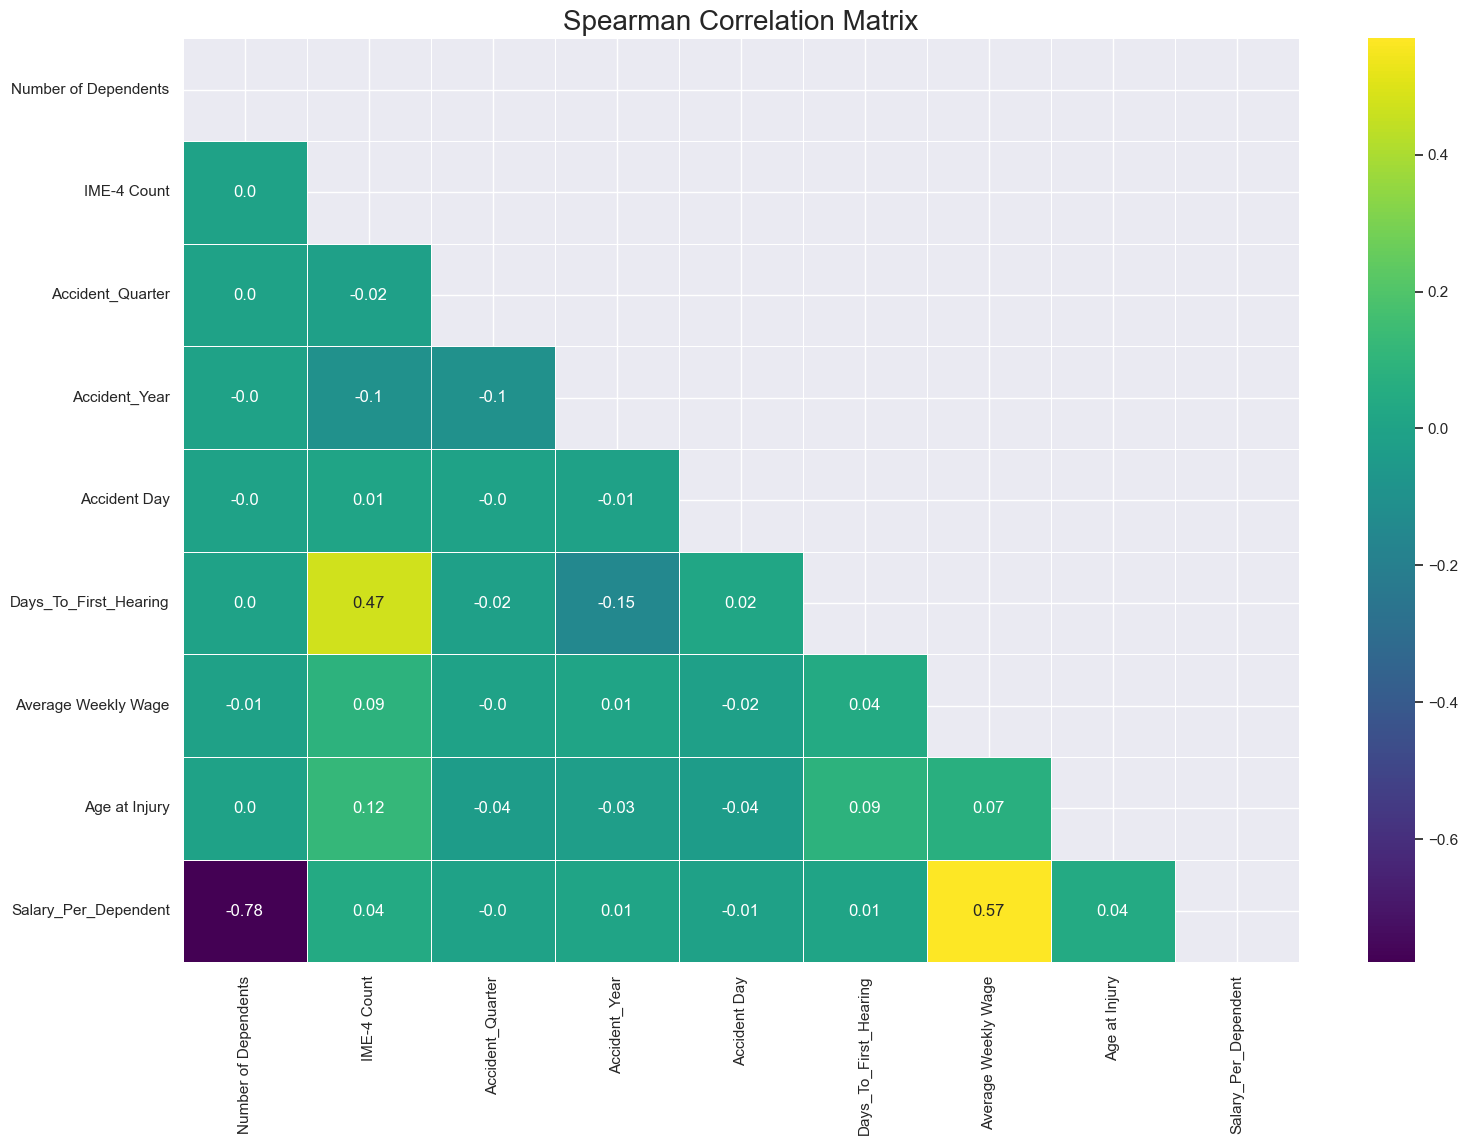

In [28]:
corr_data_numerical = X_train_num_scaled 
cor_spearman = corr_data_numerical.corr(method='spearman')

cor_heatmap(cor_spearman, 'Spearman')

### 4.2.2. LASSO Regression <a class="anchor" id="sub_section_4_2_2"></a>

 The LASSO (Least Absolute Shrinkage and Selection Operator) regression is used here for feature selection by fitting a model to the standardized dataset and analyzing the coefficients.

In [29]:
X_train_num_scaled.shape

(92619, 9)

In [30]:
# Fit regression
reg = LassoCV().fit(X_train_num_scaled, y_train_encoded)
#get coefficients
coef = pd.Series(reg.coef_, index = X_train_num_scaled.columns)
# Sort coefficients to observe importance
coef.sort_values()

Accident_Quarter         -0.027725
Average Weekly Wage       0.000000
Accident Day              0.000890
Number of Dependents      0.003373
Age at Injury             0.152061
Salary_Per_Dependent      1.086926
Accident_Year             1.477187
Days_To_First_Hearing     3.273602
IME-4 Count              11.541160
dtype: float64

**Observations:**

The LASSO model assigns non-zero coefficients only to the features it considers important.

IME-4 Count has the highest positive coefficient, indicating a strong positive relationship with the target variable, as well as Days_To_First_Hearing


Accident Day and Accident Quarter have smaller negative coefficients, implying a weaker inverse relationship with the target.

Average Weekly Wage and Number of Dependents has close to zero impact, suggesting it may not be a significant predictor in the model.

In [31]:
from utils import plot_importance, cor_heatmap

This function generates a horizontal bar plot of the feature importance values derived from the LASSO model, helping to visualize which features are prioritized by the model.

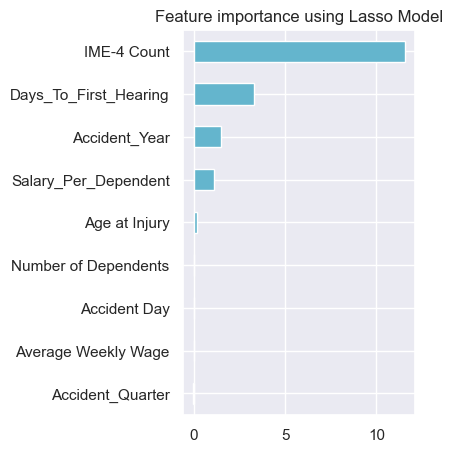

In [32]:
plot_importance(coef,'Lasso')

### 4.2.3. Recursive Feature Elimination - RFE <a class="anchor" id="sub_section_4_2_3"></a>
 RFE is employed here to further validate the important features as identified by LASSO. By sequentially removing the least important features, RFE helps to refine the feature set.

In [ ]:
# RFE using Logistic Regression
model = LogisticRegression()

#Use the function defined in utils.py
best_features, best_score, scores = find_optimal_features_with_rfe(
    model, 
    X_train_num_scaled, 
    y_train_encoded, 
    X_val_num_scaled, 
    y_val_encoded,
    max_features=9
)

Optimum number of features: 8
F1 Macro Score with 8 features: 0.235136


**Observations:**

The loop evaluates models with 1 to 9 features, tracking the score for each.

The output indicates that 2 features yielded the highest validation f1_score score of 0.483851.

#### Applying RFE with the Optimal Number of Features
Once the optimal number of features is identified, the RFE model is finalized with this configuration.

In [34]:
#rfscv- to select 1st the number of features we should select
model = LogisticRegression()
rfe = RFE(estimator = model, n_features_to_select = 8)

In [35]:
X_rfe= rfe.fit_transform(X=X_train_num_scaled, y=y_train_encoded)

This shows the results of the feature selection process, listing the features selected by RFE. The code snippet confirms which features were selected as relevant by the RFE model and displays them in a boolean Series, where True indicates the feature was selected and False means it was not.

In [36]:
selected_features = pd.Series(rfe.support_, index = X_train_num_scaled.columns)
selected_features

Number of Dependents     False
IME-4 Count               True
Accident_Quarter          True
Accident_Year             True
Accident Day              True
Days_To_First_Hearing     True
Average Weekly Wage       True
Age at Injury             True
Salary_Per_Dependent      True
dtype: bool

### 4.2.4. Feature Importance - Decision Tree <a class="anchor" id="sub_section_4_2_4"></a>

In [37]:
from utils import compare_feature_importances

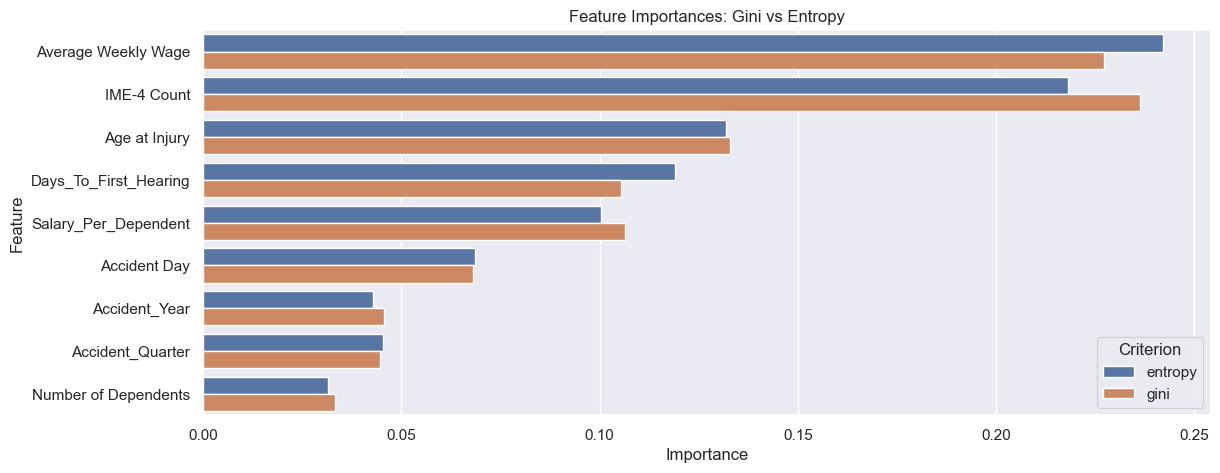

       gini   entropy                   col
0  0.033279  0.031579  Number of Dependents
1  0.236393  0.218142           IME-4 Count
2  0.044685  0.045472      Accident_Quarter
3  0.045561  0.042886         Accident_Year
4  0.067947  0.068626          Accident Day


In [38]:
# Call the function with your training data
zippy = compare_feature_importances(X_train_num_scaled, y_train_encoded)

# Access the DataFrame for further analysis if needed
print(zippy.head())

### 4.2.5. Feature Importance - Random Forest <a class="anchor" id="sub_section_4_2_5"></a>

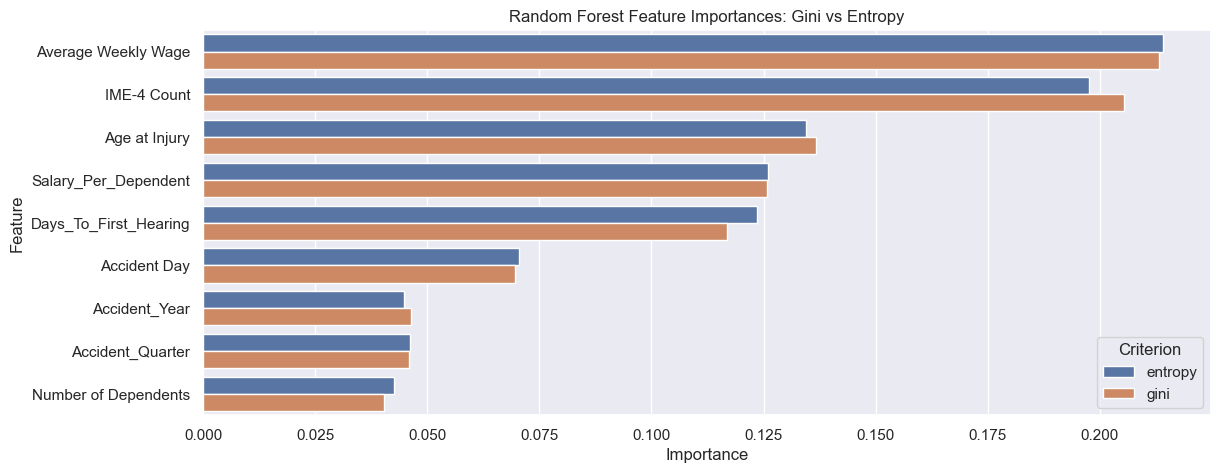

       gini   entropy                   col
0  0.040307  0.042639  Number of Dependents
1  0.205517  0.197643           IME-4 Count
2  0.045863  0.046235      Accident_Quarter
3  0.046291  0.044683         Accident_Year
4  0.069612  0.070458          Accident Day


In [39]:
# Call the function with your training data
importances = compare_rf_feature_importances(X_train_num_scaled, y_train_encoded)

# Access the DataFrame for further analysis if needed
print(importances.head())

## 4.3. Categorical Features</b> <a class="anchor" id="section_4_3"></a>
Chi-squared and MIC for the categorical ones.

 ### 4.3.1. $\chi ^2$ Test for Independence <a class="anchor" id="sub_section_4_3_1"></a>
The Chi-squared test helps us identify the most relevant categorical and binary features by evaluating their independence with the target variable. In this analysis, we set a threshold to keep the 25 most relevant features.

In [59]:
from utils import select_high_score_features_chi2_no_model

In [60]:
# Example usage
high_score_features_chi2, scores = select_high_score_features_chi2_no_model(
    X_train_mic_chi2, 
    y_train_encoded, 
    threshold=25
)

Top 25 features based on Chi-square scores: ['Industry Code_freq', 'WCIO Nature of Injury Code_freq', 'District Name_freq', 'Carrier_District_Interaction_freq', 'WCIO Part Of Body Code_freq', 'Zip_Code_Simplified_freq', 'WCIO Cause of Injury Code_freq', 'County of Injury_freq', 'Carrier Type Merged_freq', 'Carrier_Name_Simplified_freq', 'Attorney/Representative', 'Body_Part_Category_Trunk', 'promptness_C3_category', 'Income_Category', 'Injury_Cause_Category_Strain or Injury By', 'Body_Part_Category_Upper Extremities', 'promptness_category', 'COVID-19 Indicator', 'Injury_Cause_Category_COVID-19 Injury', 'Industry Risk', 'promptness_C2_category', 'Body_Part_Category_Lower Extremities', 'Body_Part_Category_Neck', 'Injury_Cause_Category_Cut, Puncture, Scrape', 'Body_Part_Category_Multiple Body Parts']
Corresponding Chi-square scores: [34247369.59787084, 27207395.448234703, 16744948.698556816, 9077379.654413937, 6326082.074213176, 5853758.13764526, 2120258.179857621, 2025272.1137818254, 591

In [61]:
high_score_features_chi2

['Industry Code_freq',
 'WCIO Nature of Injury Code_freq',
 'District Name_freq',
 'Carrier_District_Interaction_freq',
 'WCIO Part Of Body Code_freq',
 'Zip_Code_Simplified_freq',
 'WCIO Cause of Injury Code_freq',
 'County of Injury_freq',
 'Carrier Type Merged_freq',
 'Carrier_Name_Simplified_freq',
 'Attorney/Representative',
 'Body_Part_Category_Trunk',
 'promptness_C3_category',
 'Income_Category',
 'Injury_Cause_Category_Strain or Injury By',
 'Body_Part_Category_Upper Extremities',
 'promptness_category',
 'COVID-19 Indicator',
 'Injury_Cause_Category_COVID-19 Injury',
 'Industry Risk',
 'promptness_C2_category',
 'Body_Part_Category_Lower Extremities',
 'Body_Part_Category_Neck',
 'Injury_Cause_Category_Cut, Puncture, Scrape',
 'Body_Part_Category_Multiple Body Parts']

 ### 4.3.2. Mutual Information Criterion (MIC) <a class="anchor" id="sub_section_4_3_2"></a>


The Mutual Information Criterion is used to measure the dependence between each feature and the target variable. By setting a threshold, we retain only the most relevant features.

In [62]:
from utils import select_high_score_features_MIC

In [63]:
# Example usage
high_score_features_MIC, scores_MIC = select_high_score_features_MIC(
    X_train_mic_chi2, 
    y_train_encoded, 
    threshold=25, 
    random_state=42)

Top 25 features based on MIC scores: ['Attorney/Representative', 'WCIO Part Of Body Code_freq', 'WCIO Cause of Injury Code_freq', 'WCIO Nature of Injury Code_freq', 'promptness_C3_category', 'Industry Code_freq', 'Carrier_Name_Simplified_freq', 'promptness_C2_category', 'promptness_category', 'Carrier_District_Interaction_freq', 'Body_Part_Category_Trunk', 'Income_Category', 'Industry Risk', 'Body_Part_Category_Upper Extremities', 'Injury_Cause_Category_Strain or Injury By', 'Carrier Type Merged_freq', 'County of Injury_freq', 'Age Group', 'Body_Part_Category_Lower Extremities', 'District Name_freq', 'Zip_Code_Simplified_freq', 'Injury_Nature_Category_Specific Injury', 'COVID-19 Indicator', 'Injury_Cause_Category_COVID-19 Injury', 'Gender_M']
Corresponding MIC scores: [0.19930084651267221, 0.1990319165977954, 0.16710469836195285, 0.16077675488355192, 0.09499059538342136, 0.08707692448769588, 0.06383884542135831, 0.062233500752046256, 0.044866755038655226, 0.041392094777396915, 0.040186

## 4.4. Final Features</b> <a class="anchor" id="section_4_4"></a>

The following table includes all numerical columns and a summary of actions to take based on the combined insights from **Spearman**, **Lasso**, **RFE**, **Decision Trees**, and **Random Forests**.

| **Predictor**          | **Spearman**                        | **LASSO**    | **RFE LR**       | **Decision Tree Importance** | **Random Forest Importance** | **What to do?**                          |
|-------------------------|--------------------------------------|--------------|------------------|------------------------------|--------------------------------|------------------------------------------|
| Number of Dependents    | High (-0.78 with Salary/Dependent)  | Discard      | Discard          | Low                          | Low                            | Discard                                  |
| IME-4 Count             | Moderate (-0.47 with Days to Hear)        | Keep         | Keep             | High                         | High                           | Include in the model                     |
| Accident_Quarter        | Low                                 | Discard      | Keep             | Low                          | Low                            | Discard                                  |
| Accident_Year           | Low                                 | Keep         | Keep             | Low                          | Low                            | Discard                                  |
| Accident Day            | Low                                 | Discard      | Keep             | Low                          | Low                            | Discard                                  |
| Days to First Hearing   | Moderate (-0.47 with IME-4 Count)         | Keep         | Keep             | High                          | High                           | Consider if we should include                     |
| Average Weekly Wage     | Moderate (0.57 with Salary/Dependent)| Discard      | Keep             | High                         | High                           | Include in the model                     |
| Age at Injury           | Low                                 | Discard         | Keep             | High                          | High                            | Include in the model                                   |
| Salary Per Dependent    | High (-0.78 with Dependents, 0.57 with Avg Wage) | Keep | Keep | Low | High | Discard|



**Intersection of Selected Features by Chi-squared and MIC** <BR>
To identify the most relevant categorical features, we take the intersection of features selected by both Chi-squared and MIC methods.

In [64]:
# Find common features between Chi-squared and MIC selections
common_categorical_features = list(set(high_score_features_chi2).intersection(set(high_score_features_MIC)))
features_selected = common_categorical_features  # Final list of selected features
features_selected  # Display the list of intersected features

['WCIO Part Of Body Code_freq',
 'District Name_freq',
 'Zip_Code_Simplified_freq',
 'promptness_C2_category',
 'Body_Part_Category_Lower Extremities',
 'promptness_category',
 'Injury_Cause_Category_Strain or Injury By',
 'COVID-19 Indicator',
 'Industry Risk',
 'Carrier_District_Interaction_freq',
 'Carrier Type Merged_freq',
 'Body_Part_Category_Trunk',
 'WCIO Cause of Injury Code_freq',
 'Income_Category',
 'County of Injury_freq',
 'Industry Code_freq',
 'promptness_C3_category',
 'Carrier_Name_Simplified_freq',
 'Attorney/Representative',
 'Injury_Cause_Category_COVID-19 Injury',
 'Body_Part_Category_Upper Extremities',
 'WCIO Nature of Injury Code_freq']

Now we will define the final_features and select then on the X_train, X_val and df_test

In [54]:
final_features = [
    # Categorical features selected through MIC and chi2
    'WCIO Part Of Body Code_freq',
    'District Name_freq',
    'Zip_Code_Simplified_freq',
    'promptness_C2_category',
    'Body_Part_Category_Lower Extremities',
    'promptness_category',
    'Injury_Cause_Category_Strain or Injury By',
    'COVID-19 Indicator',
    'Industry Risk',
    'Carrier_District_Interaction_freq',
    'Carrier Type Merged_freq',
    'Body_Part_Category_Trunk',
    'WCIO Cause of Injury Code_freq',
    'Income_Category',
    'County of Injury_freq',
    'Industry Code_freq',
    'promptness_C3_category',
    'Carrier_Name_Simplified_freq',
    'Attorney/Representative',
    'Injury_Cause_Category_COVID-19 Injury',
    'Body_Part_Category_Upper Extremities',
    'WCIO Nature of Injury Code_freq',
    # Important numerical features
    'IME-4 Count', 'Average Weekly Wage', 'Age at Injury', 'Days_To_First_Hearing'
]


# Extracting the final features from the processed datasets
X_train_final = X_train_processed_copy[final_features]
X_val_final = X_val_processed_copy[final_features]
X_test_final = df_test_processed_copy[final_features]

# Print the shape of the final datasets to confirm consistency
print(f"X_train_final shape: {X_train_final.shape}")
print(f"X_val_final shape: {X_val_final.shape}")
print(f"X_test_final shape: {X_test_final.shape}")

X_train_final shape: (92619, 26)
X_val_final shape: (40332, 26)
X_test_final shape: (387975, 26)


### 4. Build a Simple Model and Assess Performance
#### Problem Type and Model Selection
The problem we are dealing with is a classification problem since our goal is to predict the type of variable claim injury as our target variable. As it is a categorical variable we decided to try algorithms like Logistic Regression, Random Forest, XGBoost and other classification models. To start, a simple logistic regression was built due to its interpretability and ease of use. Moreover, it supports an effective starting point for further analysis and comparison against more complex models.

#### Cross-Validation for Performance Assessment
In order to assess the model’s performance we decided to use cross validation. This technique ensures a reliable evaluation by divding our data into multiple folds and having training/testing the model on different subsets. This really helps to avoid overfitting (which was a problem that from the beginning we identify we had) and provides a comprehensive view of how well the model generalizes to unseen data.

#### Metrics for Evaluation
For model evaluation we look into some metrics like:
Precision, Recall, and F1-Score given that our target variable is claim injury type, and the dataset has an imbalanced class distributions. 
Precision tells us how many of the predicted positive instances are actually positive, while recall shows how many of the actual positives were correctly predicted. **F1 Score* provides a balance between precision and recall, which is crucial when handling imbalanced data.
Even though accuracy can provide a general idea of overall correctness, it is not our main focus due to the class imbalance. Relying solely on accuracy could give misleading insights, as it may be high even if the model is not performing well on minority classes

With these metrics we ensure a global evaluation of the model, especially considering the facts above mentioned such as imbalanced dataset and helps guiding model improvement effectively.


# 5. Modelling <a class="anchor" id="chapter5"></a>
In this section, we focus on predicting the minority classes in our dataset. Since minority class prediction is often challenging due to imbalanced data, we prioritize models that handle such scenarios effectively. The chosen models include ensemble techniques like Random Forest and Gradient Boosting, known for their robustness in classification tasks, along with specialized algorithms like CatBoost and LightGBM, which are designed to handle categorical data efficiently and provide strong performance on imbalanced datasets.

## 5.1. Simple Models</b> <a class="anchor" id="section_5_1"></a>
Simple models serve as the foundation for understanding the problem and establishing a baseline for performance. These algorithms are straightforward to implement and interpret, making them ideal for initial evaluations, even in imbalanced datasets. In this section, we explore Logistic Regression, Decision Trees, and K-Nearest Neighbors (KNN) classifiers.


### 5.1.1. Logistic Regression <a class="anchor" id="sub_section_5_1_1"></a>
Logistic Regression is a simple yet effective model for binary classification tasks. While not tailored for imbalanced datasets, it serves as a baseline to compare more sophisticated methods. while Logistic Regression might not be ideal for imbalanced data, it’s included in the analysis to serve as a benchmark and provide a simple, interpretable comparison point.

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.29      0.00      0.01      7255
           1       0.58      0.82      0.68     48224
           2       0.56      0.40      0.47     33795
           3       0.00      0.00      0.00      2948
           4       0.00      0.00      0.00        68
           5       0.00      0.00      0.00       329

    accuracy                           0.57     92619
   macro avg       0.24      0.20      0.19     92619
weighted avg       0.53      0.57      0.52     92619

___________________________________________________________________________________________________________
                         

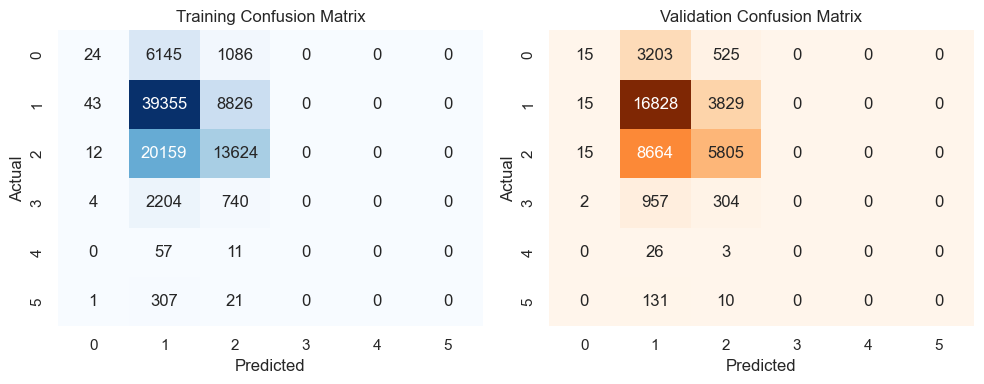

Time taken to run the cell: 11.03 seconds


In [67]:
# Initialize the Logistic Regression model
from sklearn.linear_model import LogisticRegression
import time

# Record the start time
start_time = time.time()

lr_model = LogisticRegression(random_state=42, max_iter=500)

# Fit the model to the training data
lr_model.fit(X_train_final, y_train_encoded)

# Predict on the training and validation data
y_pred_lr_train = lr_model.predict(X_train_final)
y_pred_lr_val = lr_model.predict(X_val_final)

# Evaluate the model
metrics(y_train_encoded, y_pred_lr_train, y_val_encoded, y_pred_lr_val)



While Logistic Regression is not particularly suited for imbalanced datasets, we can explore the impact of incorporating class weights to address the imbalance. This approach allows us to evaluate how adjusting the weights improves the model's sensitivity to minority classes. However, given its limitations in handling unbalanced data, our primary focus will remain on optimizing more complex and specialized models better adapted to this type of problem.

#### **Class weigths**
Class weights are used in machine learning models to address the imbalance in the dataset by assigning a higher penalty to misclassified instances of the minority class. This ensures that the model pays more attention to the underrepresented class during training, which can help improve its predictive performance on imbalanced datasets.

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.28      0.53      0.36      7255
           1       0.69      0.38      0.49     48224
           2       0.61      0.37      0.46     33795
           3       0.08      0.33      0.13      2948
           4       0.00      0.40      0.01        68
           5       0.02      0.73      0.05       329

    accuracy                           0.39     92619
   macro avg       0.28      0.46      0.25     92619
weighted avg       0.61      0.39      0.46     92619

___________________________________________________________________________________________________________
                         

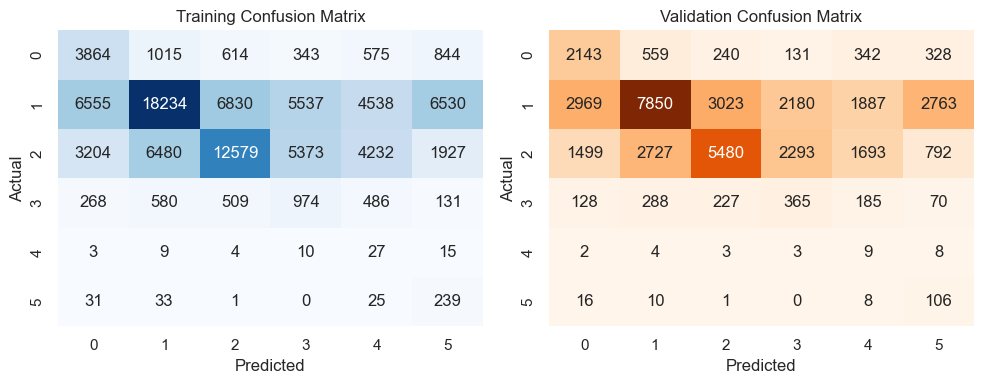

Time taken to run the cell: 9.86 seconds


In [72]:
from sklearn.linear_model import LogisticRegression
import time

# Record the start time
start_time = time.time()

# Initialize the Logistic Regression model with class weights
lr_model = LogisticRegression(random_state=42, max_iter=500, class_weight='balanced')

# Fit the model to the training data
lr_model.fit(X_train_final, y_train_encoded)

# Predict on the training and validation data
y_pred_lr_train = lr_model.predict(X_train_final)
y_pred_lr_val = lr_model.predict(X_val_final)

# Evaluate the model
metrics(y_train_encoded, y_pred_lr_train, y_val_encoded, y_pred_lr_val)

# Record the end time and calculate duration
end_time = time.time()
print(f"Time taken to run the cell: {end_time - start_time:.2f} seconds")

Although the F1 score is lower, it is evident that including class weights effectively mitigates the overfitting issue. Moving forward, we will incorporate class weights into the subsequent models to address class imbalance and improve generalization.

### 5.1.2. Decision Trees <a class="anchor" id="sub_section_5_1_2"></a>
Decision Trees are intuitive models that split the data into branches based on feature thresholds, making decisions that optimize classification purity at each step. They handle imbalanced datasets better with adjustments such as class weights.

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7255
           1       1.00      1.00      1.00     48224
           2       1.00      1.00      1.00     33795
           3       1.00      1.00      1.00      2948
           4       1.00      1.00      1.00        68
           5       1.00      1.00      1.00       329

    accuracy                           1.00     92619
   macro avg       1.00      1.00      1.00     92619
weighted avg       1.00      1.00      1.00     92619

___________________________________________________________________________________________________________
                         

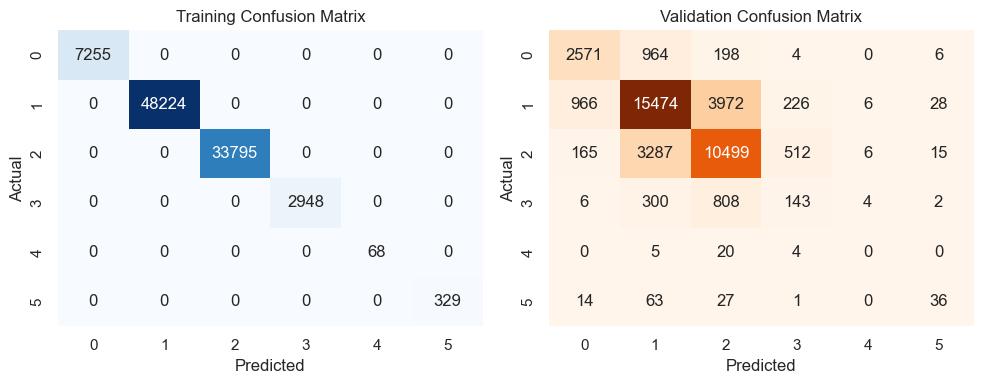

Time taken to run the cell: 1.51 seconds


In [73]:
from sklearn.tree import DecisionTreeClassifier
import time

# Record the start time
start_time = time.time()

# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# Fit the model to the training data
dt_model.fit(X_train_final, y_train_encoded)

# Predict on the training and validation data
y_pred_dt_train = dt_model.predict(X_train_final)
y_pred_dt_val = dt_model.predict(X_val_final)

# Evaluate the model
metrics(y_train_encoded, y_pred_dt_train, y_val_encoded, y_pred_dt_val)

# Record the end time and calculate duration
end_time = time.time()
print(f"Time taken to run the cell: {end_time - start_time:.2f} seconds")

In this scenario, overfitting remains an issue. To address this, we can manually adjust the class weights to mitigate its effects, ensuring the model places more emphasis on the minority classes during training. This approach involves assigning higher weights to underrepresented classes and lower weights to overrepresented ones. Below is the process for adding manual class weights:

In [77]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute the normal class weights
classes = np.unique(y_train_encoded)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_encoded)
class_weights_dict = dict(zip(classes, class_weights))

# Print the computed class weights
print("Computed Class Weights:")
print(class_weights_dict)

Computed Class Weights:
{0: 2.1277050310130945, 1: 0.3200999502322495, 2: 0.456768752774079, 3: 5.236261872455902, 4: 227.00735294117646, 5: 46.91945288753799}


In [57]:
manual_class_weights = {
    '0': 2.12, 
    '1': 0.1, 
    '2': 0.3,     
    '3': 10.0,
    '4': 300.0,
    '5': 90.0
}

# Get unique classes in y_train_encoded
unique_classes = list(set(y_train_encoded))

# Ensure class weights only include keys for existing classes
adjusted_class_weights = {k: manual_class_weights[k] for k in unique_classes if k in manual_class_weights}

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7255
           1       1.00      1.00      1.00     48224
           2       1.00      1.00      1.00     33795
           3       1.00      1.00      1.00      2948
           4       1.00      1.00      1.00        68
           5       1.00      1.00      1.00       329

    accuracy                           1.00     92619
   macro avg       1.00      1.00      1.00     92619
weighted avg       1.00      1.00      1.00     92619

___________________________________________________________________________________________________________
                         

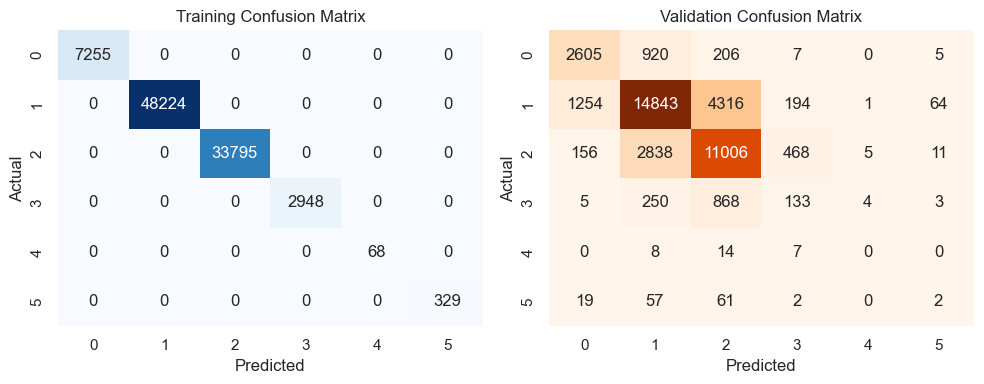

Time taken to run the cell: 3.21 seconds


In [87]:
# Record the start time
start_time = time.time()

# Initialize the Decision Tree model with manual class weights
dt_model_class = DecisionTreeClassifier(random_state=42, class_weight=adjusted_class_weights)

# Fit the model to the training data
dt_model_class.fit(X_train_final, y_train_encoded)

# Predict on the training and validation data
y_pred_dt_train_class = dt_model_class.predict(X_train_final)
y_pred_dt_val_class = dt_model_class.predict(X_val_final)

# Evaluate the model
metrics(y_train_encoded, y_pred_dt_train_class, y_val_encoded, y_pred_dt_val_class)

# Record the end time and calculate duration
end_time = time.time()
print(f"Time taken to run the cell: {end_time - start_time:.2f} seconds")


**Grid Search**

Grid Search is a systematic method for hyperparameter tuning in machine learning models. It tests all possible combinations of specified hyperparameters to find the configuration that yields the best performance on a given validation metric. The process involves:

Defining a parameter grid with potential values for each hyperparameter.
Evaluating the model's performance using cross-validation for every parameter combination.
Selecting the best combination based on a scoring metric (e.g., accuracy, F1-score).
While Grid Search can be computationally expensive, it ensures that the best hyperparameter combination is selected systematically.

In [90]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import time

# Define the parameter grid for Grid Search
param_grid = {
    'max_depth': [3, 5, 10, 15,  None],         # Tree depth
    'min_samples_split': [2, 5, 10, 15, 30],      # Minimum samples required to split
    'min_samples_leaf': [1, 2, 5, 10, 15, 30]       # Minimum samples required at a leaf node
}

# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42, class_weight=adjusted_class_weights)

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid,
    scoring='f1_macro',  # Scoring metric
    cv=5,                # Number of folds in cross-validation
    n_jobs=-1,           # Use all available CPUs
    verbose=1            # Display progress
)

# Record the start time
start_time = time.time()

# Fit Grid Search to the training data
grid_search.fit(X_train_final, y_train_encoded)

# Record the end time
end_time = time.time()

# Output the best parameters and corresponding score
print("Best Parameters:", grid_search.best_params_)
print(f"Best F1-Score: {grid_search.best_score_:.4f}")
print(f"Time taken for Grid Search: {end_time - start_time:.2f} seconds")


Fitting 5 folds for each of 150 candidates, totalling 750 fits
Best Parameters: {'max_depth': 15, 'min_samples_leaf': 15, 'min_samples_split': 2}
Best F1-Score: 0.5044
Time taken for Grid Search: 137.80 seconds


Metrics for Decision Tree (Training and Validation):
___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.66      0.75      7255
           1       0.86      0.87      0.87     48224
           2       0.81      0.88      0.84     33795
           3       0.67      0.34      0.45      2948
           4       0.00      0.00      0.00        68
           5       0.59      0.44      0.51       329

    accuracy                           0.84     92619
   macro avg       0.63      0.53      0.57     92619
weighted avg       0.84      0.84      0.83     92619

________________________________________________________________________________

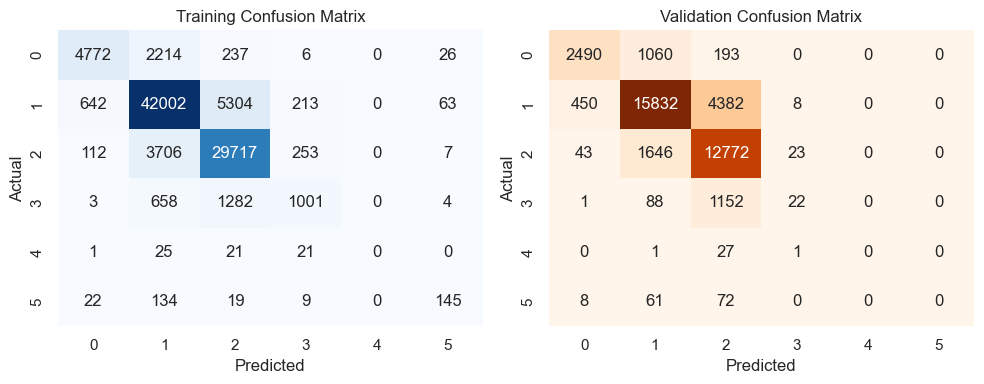

In [91]:
# Initialize the Decision Tree model with the best parameters
best_params = grid_search.best_params_
dt_best_model = DecisionTreeClassifier(
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)

# Fit the model with the best parameters to the training data
dt_best_model.fit(X_train_final, y_train_encoded)

# Predict on the training and validation datasets
y_pred_dt_train = dt_best_model.predict(X_train_final)
y_pred_dt_val = dt_best_model.predict(X_val_final)

# Evaluate the performance using metrics function
print("Metrics for Decision Tree (Training and Validation):")
metrics(y_train_encoded, y_pred_dt_train, y_val_encoded, y_pred_dt_val)

### 5.1.3. K-Nearest Neighbors (KNN) <a class="anchor" id="sub_section_5_1_3"></a>

KNN is a distance-based algorithm that predicts the class of a data point by considering the majority class among its nearest neighbors. It is sensitive to class imbalance, so preprocessing like scaling and balancing techniques are essential for effective results.

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.63      0.70      7255
           1       0.84      0.87      0.85     48224
           2       0.80      0.85      0.83     33795
           3       0.77      0.30      0.43      2948
           4       0.00      0.00      0.00        68
           5       0.75      0.27      0.39       329

    accuracy                           0.82     92619
   macro avg       0.66      0.49      0.53     92619
weighted avg       0.82      0.82      0.82     92619

___________________________________________________________________________________________________________
                         

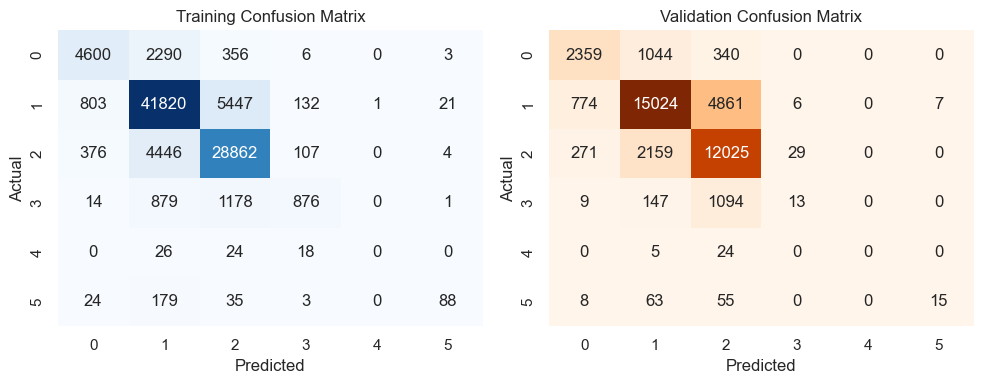

Time taken to run the cell: 34.65 seconds


In [55]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import time

# Record the start time
start_time = time.time()

# Create a pipeline with StandardScaler and KNN
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('knn', KNeighborsClassifier(n_neighbors=5))  # Initialize KNN
])

# Fit the pipeline to the training data
knn_pipeline.fit(X_train_final, y_train_encoded)

# Predict on the training and validation data
y_pred_knn_train = knn_pipeline.predict(X_train_final)
y_pred_knn_val = knn_pipeline.predict(X_val_final)

# Evaluate the model
metrics(y_train_encoded, y_pred_knn_train, y_val_encoded, y_pred_knn_val)

# Record the end time and calculate duration
end_time = time.time()
print(f"Time taken to run the cell: {end_time - start_time:.2f} seconds")

Despite scaling the features, the KNN model still exhibits overfitting. To address this, we will:

-  Apply Grid Search: As explained earlier, it helps find the best hyperparameters by evaluating multiple combinations systematically.
- Use SMOTE (Synthetic Minority Oversampling Technique): This technique balances the dataset by generating synthetic samples for the minority classes, improving model performance on imbalanced datasets.

**SMOTE**

SMOTE is a resampling technique used in machine learning to handle imbalanced datasets. It generates synthetic samples for the minority classes by interpolating between existing minority class samples. This helps the model better learn patterns for the underrepresented classes.

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.preprocessing import StandardScaler
# from imblearn.over_sampling import SMOTE
# import time

# # Scale the data
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train_final)
# X_val_scaled = scaler.transform(X_val_final)

# # Balance the training data using SMOTE
# smote = SMOTE(random_state=42)
# X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train_encoded)

# # Hyperparameter tuning with GridSearchCV
# param_grid = {
#     'n_neighbors': [3, 5, 7, 9, 11],
#     'weights': ['uniform', 'distance'],
#     'p': [1, 2]  # Manhattan and Euclidean distance
# }

# knn = KNeighborsClassifier()
# grid_search = GridSearchCV(knn, param_grid, scoring='f1_macro', cv=5, n_jobs=-1)

# # Train the optimized model
# start_time = time.time()
# grid_search.fit(X_train_balanced, y_train_balanced)
# end_time = time.time()

# # Best hyperparameters
# print("Best Parameters:", grid_search.best_params_)

# #Evaluate the model
# best_knn = grid_search.best_estimator_
# y_pred_knn_train = best_knn.predict(X_train_scaled)
# y_pred_knn_val = best_knn.predict(X_val_scaled)

# print("\nMetrics for Optimized KNN Classifier:")
# metrics(y_train_encoded, y_pred_knn_train, y_val_encoded, y_pred_knn_val)
# print(f"Time taken: {end_time - start_time:.2f} seconds")

## 5.2. Deep Learning Methods</b> <a class="anchor" id="section_5_2"></a>
Deep learning methods are powerful tools for capturing complex and non-linear relationships in data. These models are particularly useful for large datasets with intricate patterns, but they require careful tuning to avoid overfitting, especially in imbalanced datasets like ours. One advantage of neural networks is their flexibility to model interactions between features automatically, but they also demand more computational resources and expertise in fine-tuning.

Here, we explore a simple feed-forward neural network implemented using the TensorFlow library. To address the imbalance issue in the dataset, we'll apply class weights during training, ensuring that the minority classes are properly accounted for.

### 5.2.1. Feed-Forward Neural Network <a class="anchor" id="sub_section_5_2_1"></a>

A feed-forward neural network is one of the most basic forms of neural networks. It consists of input layers, hidden layers with activation functions, and an output layer for predictions. This structure makes it versatile and applicable to binary or multi-class classification problems.

Epoch 1/30
1448/1448 [==============================] - 6s 3ms/step - loss: 356.7357 - accuracy: 0.4333 - val_loss: 11.4583 - val_accuracy: 0.3538
Epoch 2/30
1448/1448 [==============================] - 5s 3ms/step - loss: 8.1563 - accuracy: 0.4342 - val_loss: 4.7753 - val_accuracy: 0.1572
Epoch 3/30
1448/1448 [==============================] - 4s 2ms/step - loss: 2.9710 - accuracy: 0.4478 - val_loss: 1.9687 - val_accuracy: 0.5101
Epoch 4/30
1448/1448 [==============================] - 4s 2ms/step - loss: 1.6196 - accuracy: 0.4689 - val_loss: 1.4412 - val_accuracy: 0.4984
Epoch 5/30
1448/1448 [==============================] - 4s 3ms/step - loss: 1.2483 - accuracy: 0.4915 - val_loss: 1.1409 - val_accuracy: 0.4650
Epoch 6/30
1448/1448 [==============================] - 4s 3ms/step - loss: 1.0895 - accuracy: 0.5204 - val_loss: 1.0645 - val_accuracy: 0.5409
Epoch 7/30
1448/1448 [==============================] - 4s 3ms/step - loss: 1.0416 - accuracy: 0.5438 - val_loss: 1.0374 - val_accura

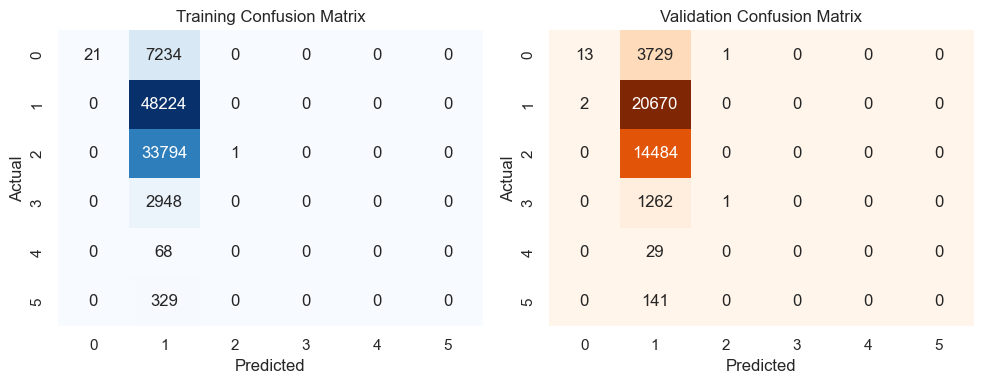

In [64]:
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import time

# Define the model
def create_model_with_manual_weights(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_dim=input_dim),
        tf.keras.layers.Dropout(0.3),  # Regularization
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(len(manual_class_weights), activation='softmax')  # Output layer for multi-class
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',  # Suitable for integer labels
        metrics=['accuracy']
    )
    return model

# Record the start time
start_time = time.time()

# Initialize the model
input_dim = X_train_final.shape[1]
nn_model_manual_weights = create_model_with_manual_weights(input_dim)

# Train the model with corrected manual class weights
nn_model_manual_weights.fit(
    X_train_final,
    y_train_encoded,
    validation_data=(X_val_final, y_val_encoded),
    epochs=30,
    batch_size=64,
    verbose=1
)

# Record the end time
end_time = time.time()
print(f"Time taken to train the model: {end_time - start_time:.2f} seconds")

# Predict on training and validation data
y_pred_nn_train_manual = np.argmax(nn_model_manual_weights.predict(X_train_final), axis=1)
y_pred_nn_val_manual = np.argmax(nn_model_manual_weights.predict(X_val_final), axis=1)

# Evaluate using the metrics() function
print("\nMetrics for Neural Network:")
metrics(y_train_encoded, y_pred_nn_train_manual, y_val_encoded, y_pred_nn_val_manual)

The previous neural network model struggled to predict certain classes effectively and exhibited poor F1-scores, particularly for underrepresented classes. To address these issues, the following improvements are implemented:

1. Scaling: Features are standardized using StandardScaler, ensuring better convergence and stability for the neural network.
2. Class Weights: Dynamically computed class weights are applied to give more importance to minority classes during training.
3. Callbacks:
- Early Stopping: Stops training when validation performance stops improving to prevent overfitting.
- Learning Rate Adjustment: Reduces the learning rate when validation loss plateaus, enabling smoother convergence.

In [70]:
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

# Define the function to create the model
def create_model(input_dim, activation='relu', class_weights=None):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation=activation, input_dim=input_dim),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(64, activation=activation),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(len(class_weights), activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Function to scale the data
def scale_data(X_train, X_val, scaling_method='standard'):
    if scaling_method == 'standard':
        scaler = StandardScaler()
    elif scaling_method == 'minmax':
        scaler = MinMaxScaler()
    else:
        raise ValueError(f"Unknown scaling method: {scaling_method}")
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    return X_train_scaled, X_val_scaled


In [77]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score
import numpy as np
import tensorflow as tf

# Define the model creation function
def create_model(input_dim, activation='relu'):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation=activation, input_dim=input_dim),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(64, activation=activation),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(6, activation='softmax')  # Adjust for the number of classes
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Scaling function
def scale_data(X_train, X_val, method):
    if method == 'standard':
        scaler = StandardScaler()
    elif method == 'minmax':
        scaler = MinMaxScaler()
    else:
        raise ValueError("Invalid scaling method. Choose 'standard' or 'minmax'.")
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    return X_train_scaled, X_val_scaled

# Compute class weights dynamically
classes = np.unique(y_train_encoded)
class_weights_dict = dict(zip(classes, compute_class_weight('balanced', classes=classes, y=y_train_encoded)))

# KerasClassifier wrapper
input_dim = X_train_final.shape[1]
model = KerasClassifier(
    model=create_model,
    input_dim=input_dim,
    verbose=0
)

# Define the parameter grid
param_grid = {
    'model__activation': ['relu', 'tanh', 'sigmoid'],  # Adjust for activation
    'batch_size': [32, 64],
    'epochs': [30, 50]
}

# Perform grid search
scaling_methods = ['standard', 'minmax']
results = []

for scaling_method in scaling_methods:
    # Scale the data
    X_train_scaled, X_val_scaled = scale_data(X_train_final, X_val_final, method=scaling_method)
    
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='f1_macro',
        cv=3,
        verbose=1
    )
    
    # Fit grid search
    grid_result = grid.fit(
        X_train_scaled,
        y_train_encoded,
        class_weight=class_weights_dict  # Pass class weights directly
    )
    
    # Append results
    results.append({
        'scaling_method': scaling_method,
        'best_params': grid_result.best_params_,
        'best_f1_score': grid_result.best_score_
    })

# Display the best results
best_result = max(results, key=lambda x: x['best_f1_score'])
print(f"Best Result: {best_result}")

# Evaluate on validation set
best_model = grid.best_estimator_
y_pred_val = np.argmax(best_model.predict(X_val_scaled), axis=1)
metrics(y_val_encoded, y_pred_val, y_val_encoded, y_pred_val)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


KeyboardInterrupt: 

## 5.3. Ensemble Models</b> <a class="anchor" id="section_5_3"></a>
Ensemble models combine predictions from multiple base models to improve performance. These methods are robust to overfitting and perform well on imbalanced datasets when combined with appropriate class balancing techniques.

### 5.3.1. Bagging <a class="anchor" id="sub_section_5_3_1"></a>
Bagging methods, such as Random Forest, aggregate predictions from multiple models trained on bootstrap samples. This reduces variance and enhances generalization.
Random Forest is an ensemble learning method that builds multiple decision trees and averages their predictions. It can handle imbalanced datasets relatively well by adjusting class weights.

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7255
           1       1.00      1.00      1.00     48224
           2       1.00      1.00      1.00     33795
           3       1.00      1.00      1.00      2948
           4       1.00      1.00      1.00        68
           5       1.00      1.00      1.00       329

    accuracy                           1.00     92619
   macro avg       1.00      1.00      1.00     92619
weighted avg       1.00      1.00      1.00     92619

___________________________________________________________________________________________________________
                         

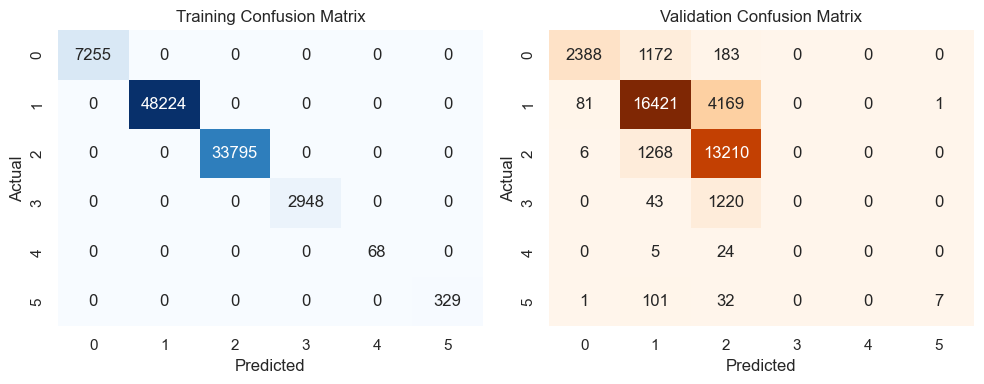

Time taken to run the cell: 26.30 seconds


In [63]:
# Initialize the Random Forest model
from sklearn.ensemble import RandomForestClassifier

# Record the start time
start_time = time.time()

rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Fit the model to the training data
rf_model.fit(X_train_final, y_train_encoded)

# Predict on the training and validation data
y_pred_rf_train = rf_model.predict(X_train_final)
y_pred_rf_val = rf_model.predict(X_val_final)

# Evaluate the model
metrics(y_train_encoded, y_pred_rf_train, y_val_encoded, y_pred_rf_val)

# Record the end time and calculate duration
end_time = time.time()
print(f"Time taken to run the cell: {end_time - start_time:.2f} seconds")


The Random Forest model, even with the use of class_weight='balanced', continues to show signs of overfitting. This indicates that while class weights have helped mitigate class imbalance to some extent, additional hyperparameter tuning is required to achieve a better balance between performance on the training and validation sets. To address this, we will implement a Grid Search approach, incorporating different combinations of hyperparameters and testing additional manually computed class weights to find the best configuration.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import time

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 500],  # Number of trees in the forest
    'max_depth': [10, 20, 30, None],  # Depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required to be a leaf node
    'class_weight': ['balanced', {0: 2.0, 1: 1.0, 2: 0.5, 3: 5.0, 4: 10.0, 5: 20.0}]  # Class weights
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='f1_macro',  # Evaluate using F1-score
    cv=3,  # 3-fold cross-validation
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Record the start time
start_time = time.time()

# Fit GridSearchCV
grid_search.fit(X_train_final, y_train_encoded)

# Record the end time and calculate duration
end_time = time.time()
print(f"Time taken to run the grid search: {end_time - start_time:.2f} seconds")

# Best parameters and performance
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best F1-Score: {grid_search.best_score_:.4f}")

# Evaluate the best model on the validation set
best_rf_model = grid_search.best_estimator_
y_pred_rf_val = best_rf_model.predict(X_val_final)

# Metrics evaluation
metrics(y_train_encoded, y_pred_rf_train, y_val_encoded, y_pred_rf_val)

### 5.2.2. Boosting <a class="anchor" id="sub_section_5_2_2"></a>
Boosting methods, including XGBoost, LightGBM, and CatBoost, sequentially train models to correct errors from previous iterations. These are powerful tools for imbalanced datasets due to their ability to focus on harder-to-classify examples.


#### **XGBoost**

XGBoost is a gradient boosting algorithm that is highly effective for classification tasks, especially on imbalanced datasets. It uses regularization to reduce overfitting and improve generalization.

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.76      0.84      7255
           1       0.90      0.90      0.90     48224
           2       0.85      0.92      0.88     33795
           3       0.82      0.52      0.64      2948
           4       1.00      1.00      1.00        68
           5       0.98      0.99      0.99       329

    accuracy                           0.88     92619
   macro avg       0.92      0.85      0.87     92619
weighted avg       0.88      0.88      0.88     92619

___________________________________________________________________________________________________________
                         

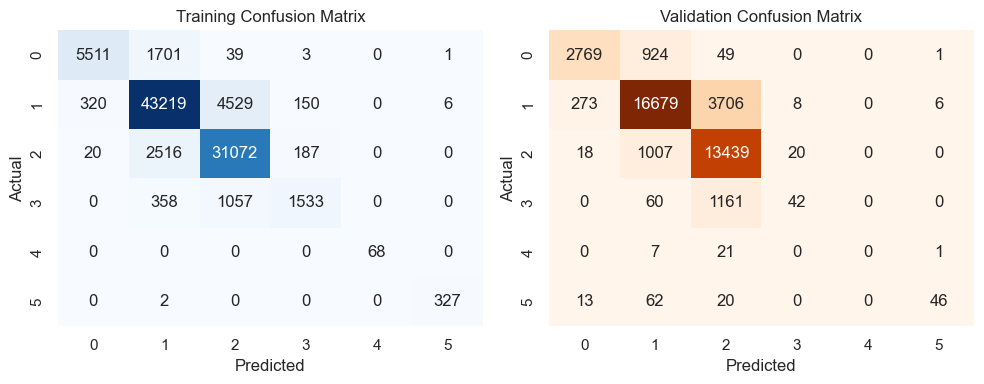

Time taken to run the cell: 6.23 seconds


In [69]:
# Initialize the XGBoost model
from xgboost import XGBClassifier

# Record the start time
start_time = time.time()

xgb_model = XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False)

# Fit the model to the training data
xgb_model.fit(X_train_final, y_train_encoded)

# Predict on the training and validation data
y_pred_xgb_train = xgb_model.predict(X_train_final)
y_pred_xgb_val = xgb_model.predict(X_val_final)

# Evaluate the model
metrics(y_train_encoded, y_pred_xgb_train, y_val_encoded, y_pred_xgb_val)

# Record the end time and calculate duration
end_time = time.time()
print(f"Time taken to run the cell: {end_time - start_time:.2f} seconds")

In the current implementation, the XGBoost model shows promising results with a lower degree of overfitting compared to other models. However, there is still room for improvement, particularly in the performance of minority classes. To address this, we will perform a Grid Search to optimize the hyperparameters and improve the model's overall performance.

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import time

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1, 2, 5]  # For class imbalance
}

# Initialize the XGBoost model
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1_macro',  # Evaluate using F1-score
    cv=3,  # 3-fold cross-validation
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Record the start time
start_time = time.time()

# Fit GridSearchCV
grid_search.fit(X_train_final, y_train_encoded)

# Record the end time and calculate duration
end_time = time.time()
print(f"Time taken to run the grid search: {end_time - start_time:.2f} seconds")

# Display the best parameters and F1-score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best F1-Score: {grid_search.best_score_:.4f}")

# Evaluate the best model on the validation set
best_xgb_model = grid_search.best_estimator_
y_pred_xgb_val = best_xgb_model.predict(X_val_final)

# Evaluate metrics on the validation set
metrics(y_train_encoded, y_pred_xgb_train, y_val_encoded, y_pred_xgb_val)

#### **LightGBM**

LightGBM is a gradient boosting framework designed for fast training and low memory usage. It works well with large datasets and can efficiently handle imbalanced data

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1147
[LightGBM] [Info] Number of data points in the train set: 92619, number of used features: 26
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
___________________________________________________________________________________________________________
                                                     TRAIN                                                 
---------------------------

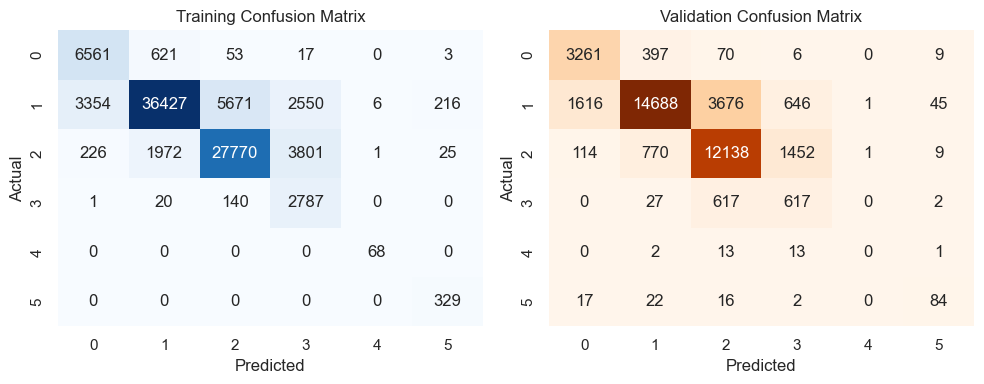

Time taken to run the cell: 9.34 seconds


In [71]:
# Initialize the LightGBM model
from lightgbm import LGBMClassifier

# Record the start time
start_time = time.time()

lgbm_model = LGBMClassifier(random_state=42, class_weight='balanced')

# Fit the model to the training data
lgbm_model.fit(X_train_final, y_train_encoded)

# Predict on the training and validation data
y_pred_lgbm_train = lgbm_model.predict(X_train_final)
y_pred_lgbm_val = lgbm_model.predict(X_val_final)

# Evaluate the model
metrics(y_train_encoded, y_pred_lgbm_train, y_val_encoded, y_pred_lgbm_val)

# Record the end time and calculate duration
end_time = time.time()
print(f"Time taken to run the cell: {end_time - start_time:.2f} seconds")


#### **CatBoost**

CatBoost is a gradient boosting algorithm specifically optimized for categorical data. It handles imbalanced datasets effectively and reduces the need for extensive preprocessing.

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.72      0.81      7255
           1       0.89      0.89      0.89     48224
           2       0.83      0.91      0.87     33795
           3       0.78      0.46      0.58      2948
           4       1.00      0.84      0.91        68
           5       0.95      0.90      0.93       329

    accuracy                           0.87     92619
   macro avg       0.90      0.79      0.83     92619
weighted avg       0.87      0.87      0.87     92619

___________________________________________________________________________________________________________
                         

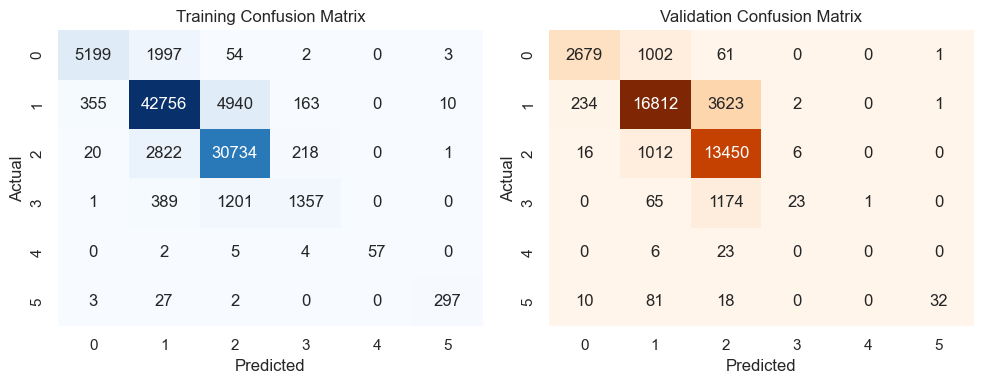

Time taken to run the cell: 81.49 seconds


In [75]:
# Initialize the CatBoost model
from catboost import CatBoostClassifier

# Record the start time
start_time = time.time()

catboost_model = CatBoostClassifier(random_state=42, verbose=0)

# Fit the model to the training data
catboost_model.fit(X_train_final, y_train_encoded)

# Predict on the training and validation data
y_pred_catboost_train = catboost_model.predict(X_train_final)
y_pred_catboost_val = catboost_model.predict(X_val_final)

# Evaluate the model
metrics(y_train_encoded, y_pred_catboost_train, y_val_encoded, y_pred_catboost_val)

# Record the end time and calculate duration
end_time = time.time()
print(f"Time taken to run the cell: {end_time - start_time:.2f} seconds")


### 5.2.3. Stacking <a class="anchor" id="sub_section_5_2_3"></a>
Stacking combines predictions from multiple base models by training a meta-model on their outputs. This leverages the strengths of various algorithms to improve overall performance.

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.88      0.93      7255
           1       0.95      0.94      0.94     48224
           2       0.92      0.95      0.93     33795
           3       0.97      0.99      0.98      2948
           4       0.00      0.00      0.00        68
           5       0.99      1.00      1.00       329

    accuracy                           0.94     92619
   macro avg       0.80      0.79      0.80     92619
weighted avg       0.94      0.94      0.94     92619

___________________________________________________________________________________________________________
                         

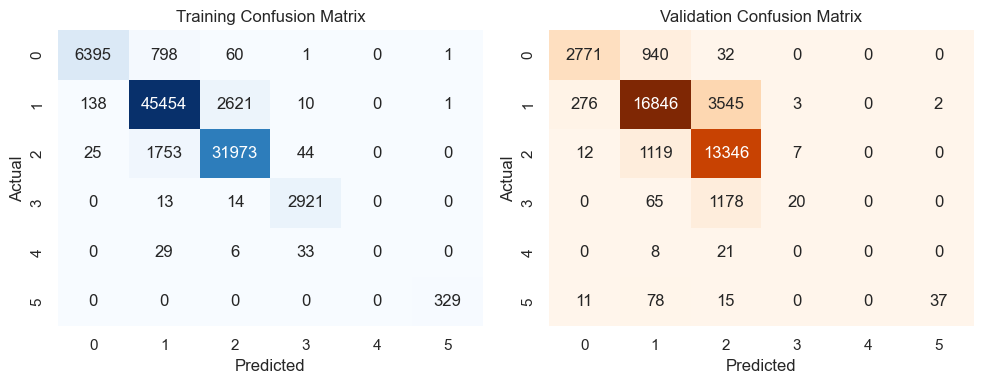

In [76]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Define base models
base_models = [
    ('rf', RandomForestClassifier(random_state=42, class_weight='balanced')),
    ('xgb', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')),
]

# Initialize the meta-model
meta_model = LogisticRegression(random_state=42)

# Initialize the Stacking model
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Fit the model to the training data
stacking_model.fit(X_train_final, y_train_encoded)

# Predict on the training and validation data
y_pred_stack_train = stacking_model.predict(X_train_final)
y_pred_stack_val = stacking_model.predict(X_val_final)

# Evaluate the model
metrics(y_train_encoded, y_pred_stack_train, y_val_encoded, y_pred_stack_val)

## 5.4. Summary of Models </b> <a class="anchor" id="section_5_4"></a>


We focused on a select set of models for binary classification as the initial results provided promising performance metrics. Below is the performance table, including F1 scores for training and validation datasets, along with the time taken for each model to run.

| **Model**             | **F1 Score (Train)** | **F1 Score (Validation)** | **Time (seconds)** |
|------------------------|----------------------|----------------------------|---------------------|
|                        |                      |                            |                     |
|                        |                      |                            |                     |
|                        |                      |                            |                     |
|                        |                      |                            |                     |
|                        |                      |                            |                     |

# 6. Loading the Results <a class="anchor" id="chapter6"></a>

In [54]:
# from sklearn.preprocessing import LabelEncoder

# # Reindexar as classes
# le = LabelEncoder()

# # Ajustar e transformar as classes de treinamento e validação
# y_train_encoded = le.fit_transform(y_train_1_3_5_6_7_8)
# y_val_encoded = le.transform(y_val_1_3_5_6_7_8)

# # Treinar o modelo XGBoost
# xgb_model = XGBClassifier(objective='multi:softmax', num_class=len(le.classes_), 
#                           random_state=42, n_estimators=200, learning_rate=0.1, max_depth=6)
# xgb_model.fit(X_train_1_3_5_6_7_8, y_train_encoded)

# # Fazer previsões
# val_predictions_xgb = xgb_model.predict(X_val_1_3_5_6_7_8)

# # Decodificar as previsões de volta para os rótulos originais
# val_predictions_decoded = le.inverse_transform(val_predictions_xgb)

# # Avaliar o desempenho
# val_accuracy_xgb = accuracy_score(y_val_1_3_5_6_7_8, val_predictions_decoded)
# print(f"Acurácia no conjunto de validação com XGBoost: {val_accuracy_xgb:.4f}")

# # Relatório de Classificação
# print("\nRelatório de Classificação (XGBoost):")
# print(classification_report(y_val_1_3_5_6_7_8, val_predictions_decoded))

# # Matriz de Confusão
# print("\nMatriz de Confusão (XGBoost):")
# print(confusion_matrix(y_val_1_3_5_6_7_8, val_predictions_decoded))




Acurácia no conjunto de validação com XGBoost: 0.8080

Relatório de Classificação (XGBoost):
              precision    recall  f1-score   support

           1       0.92      0.71      0.80      3743
           3       0.89      0.79      0.84     20672
           5       0.71      0.93      0.81     14484
           6       0.58      0.03      0.05      1263
           7       0.00      0.00      0.00        29
           8       0.83      0.37      0.51       141

    accuracy                           0.81     40332
   macro avg       0.65      0.47      0.50     40332
weighted avg       0.82      0.81      0.80     40332


Matriz de Confusão (XGBoost):
[[ 2650   933   157     0     0     3]
 [  208 16404  4040    12     0     8]
 [   23  1002 13446    13     0     0]
 [    0    73  1154    36     0     0]
 [    0     5    23     1     0     0]
 [    8    62    19     0     0    52]]


In [57]:
# from sklearn.ensemble import RandomForestClassifier

# # Treinar o modelo Random Forest
# rf_model = RandomForestClassifier(random_state=42, n_estimators=200)
# rf_model.fit(X_train_1_3_5_6_7_8, y_train_1_3_5_6_7_8)

# # Fazer previsões
# val_predictions_rf = rf_model.predict(X_val_1_3_5_6_7_8)

# # Avaliar o desempenho
# val_accuracy_rf = accuracy_score(y_val_1_3_5_6_7_8, val_predictions_rf)
# print(f"Acurácia no conjunto de validação com Random Forest: {val_accuracy_rf:.4f}")

# # Relatório de Classificação
# print("\nRelatório de Classificação (Random Forest):")
# print(classification_report(y_val_1_3_5_6_7_8, val_predictions_rf))

# # Matriz de Confusão
# print("\nMatriz de Confusão (Random Forest):")
# print(confusion_matrix(y_val_1_3_5_6_7_8, val_predictions_rf))



Acurácia no conjunto de validação com Random Forest: 0.7815

Relatório de Classificação (Random Forest):
              precision    recall  f1-score   support

           1       0.97      0.63      0.76      3743
           3       0.88      0.76      0.81     20672
           5       0.67      0.93      0.78     14484
           6       1.00      0.00      0.00      1263
           7       0.00      0.00      0.00        29
           8       1.00      0.04      0.08       141

    accuracy                           0.78     40332
   macro avg       0.75      0.39      0.41     40332
weighted avg       0.82      0.78      0.77     40332


Matriz de Confusão (Random Forest):
[[ 2358  1091   294     0     0     0]
 [   69 15741  4862     0     0     0]
 [    8  1062 13414     0     0     0]
 [    0    28  1234     1     0     0]
 [    0     1    28     0     0     0]
 [    4    66    65     0     0     6]]


In [58]:
# from sklearn.neural_network import MLPClassifier

# # Treinar o modelo MLP
# mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42)
# mlp_model.fit(X_train_1_3_5_6_7_8, y_train_1_3_5_6_7_8)

# # Fazer previsões
# val_predictions_mlp = mlp_model.predict(X_val_1_3_5_6_7_8)

# # Avaliar o desempenho
# val_accuracy_mlp = accuracy_score(y_val_1_3_5_6_7_8, val_predictions_mlp)
# print(f"Acurácia no conjunto de validação com MLP: {val_accuracy_mlp:.4f}")

# # Relatório de Classificação
# print("\nRelatório de Classificação (MLP):")
# print(classification_report(y_val_1_3_5_6_7_8, val_predictions_mlp))

# # Matriz de Confusão
# print("\nMatriz de Confusão (MLP):")
# print(confusion_matrix(y_val_1_3_5_6_7_8, val_predictions_mlp))


Acurácia no conjunto de validação com MLP: 0.5372

Relatório de Classificação (MLP):
              precision    recall  f1-score   support

           1       0.95      0.01      0.01      3743
           3       0.53      0.98      0.68     20672
           5       0.71      0.10      0.18     14484
           6       0.00      0.00      0.00      1263
           7       0.00      0.00      0.00        29
           8       0.00      0.00      0.00       141

    accuracy                           0.54     40332
   macro avg       0.36      0.18      0.15     40332
weighted avg       0.61      0.54      0.42     40332


Matriz de Confusão (MLP):
[[   21  3662    60     0     0     0]
 [    1 20167   504     0     0     0]
 [    0 13007  1477     0     0     0]
 [    0  1211    52     0     0     0]
 [    0    29     0     0     0     0]
 [    0   141     0     0     0     0]]


In [ ]:
# # Filtrar linhas em que y_test == 0
# X_test_target = X_test_final[y_test == 0]

# # Remover a coluna 'Final_Predictions' se ela existir nos dados de entrada
# X_test_target = X_test_target.drop(columns=['Final_Predictions'], errors='ignore')

# # Fazer previsões nas linhas filtradas
# test_target_predictions_encoded = xgb_model.predict(X_test_target)

# # Decodificar as previsões para os rótulos originais
# test_target_predictions = le.inverse_transform(test_target_predictions_encoded)

# # Adicionar as previsões ao dataset de teste
# X_test_final.loc[y_test == 0, 'Final_Predictions'] = test_target_predictions



Final_Predictions
3.0    161111
1.0      8197
5.0      5111
6.0       479
8.0        72
Name: count, dtype: int64


In [66]:
# # Adicionar y_test ao DataFrame X_test_final
# X_test_final['Predictions'] = y_test.values
